<center><br><font size=10>Machine Learning Project</font><br>
<b>Introduction to Machine Learning</b>
<br>Industrial Engineering and Management - Tel Aviv University
    <br><b>2019</b></center>

### *<font color = 'red'>Important:<br><br>In this project we tried a lot of ways of feature engineering, among them is 2 ways of data normalization ( Z-Score VS MinMax ), we also evaluated our models with and without new columns ( clustering ). All these ways was checked side by side. Because of project running time constraints we were forced to comment out less effective ways of feature engineering, so some of our big tries still stay visible. <br>After all we choosed Z-Score to normalize our data and to add new columns ( clustering ) as we saw both of this ways gave us better perfomance of models.<br> But all other tries like way of encoding the binary features, some transformations and many many more, where erased from this notebook, so the notebook could me still readable<br>Thank you</font>*

# Contents
1. **[Exploration](#1.-Exploration)**
    * [Graphs](#Graphs)
    * [Feature correlations](#Feature-correlations)
2. **[Preprocessing](#2.-Preprocessing)**
    * [Outliers + Transformations + Clustering ](#Outliers-+-Transformations-+-Clustering)
    * [Normalization](#Normalization)
    * [Feature selection and PCA](#Feature-selection-and-PCA)
3. **[Building Models and Evaluations](#3+4.-Building-models-and-Evaluations)**
    * [Building initial models and evaluations](#Building-initial-models-and-evaluation)
        - [Logistic Regression](#Logistic-Regression)
        - [KNN](#KNN)
        - [Naive Bayes](#Naive-Bayes)
            - [Confusion Matrix](#Confusion-Matrix)
    * [Advanced Models and Evaluations](#Advanced-Models-and-Evaluations)
        - [ANN](#ANN)
        - [Random Forest](#Random-Forest)
        - [AdaBoost Classifier](#AdaBoost-Classifier)
4. **[Models Comparison](#Models-Comparison)**
5. **[Final Predictions](#Final-Predictions)**
           
         

In [369]:
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
from sklearn import decomposition
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
import matplotlib.gridspec as gridspec
%matplotlib inline
np.set_printoptions(threshold = np.inf)
import math
import scipy
import random

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

from sklearn import svm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn import neighbors


pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('train.csv')

### <font color='red'>We will transform Test set side by side with training set to have the same structure in the end</font>

In [3]:
df_test = pd.read_csv('test_without_target.csv')

In [4]:
df_test.head()

Unnamed: 0  0     1  2  3    4  5  6    7   8         9         10  \
0           0  A  10.0  E  X  1.0  e  A  1.0  c0  2.980762  26.016737   
1           1  A  10.0  D  Y  0.0  c  A  1.0  c0  2.143788   2.125067   
2           2  A  10.0  E  Q  1.0  f  A  0.0  c0  2.901297 -26.346464   
3           3  A   6.0  D  Y  0.0  a  A  1.0  c0  3.444322  23.105804   
4           4  A  10.0  D  U  0.0  c  A  0.0   ?  2.232784  12.028403   

         11           12     13          14        15          16   17   18  \
0  5.894672  1870.786667  100.0  235.202236  2.141704  543.785299  0.0  0.0   
1  4.609658  2931.860000  100.0  232.877280  0.870279  177.284459  0.0  0.0   
2  5.251290  1364.893333  100.0  232.246162  1.768367  102.037179  0.0  0.0   
3  6.211432   719.940000   70.0  194.036711  0.904343  230.405861  0.0  0.0   
4  4.316353   361.013333  100.0  231.494241  2.096840  193.980788  0.0  0.0   

     19   20  
0  80.0  4.0  
1  30.0  2.0  
2  80.0  5.0  
3  90.0  8.0  
4  60.0  4.0

In [5]:
df_test.drop(['Unnamed: 0'],axis=1,inplace = True)

In [6]:
df_test.head(2)

0     1  2  3    4  5  6    7   8         9         10        11  \
0  A  10.0  E  X  1.0  e  A  1.0  c0  2.980762  26.016737  5.894672   
1  A  10.0  D  Y  0.0  c  A  1.0  c0  2.143788   2.125067  4.609658   

            12     13          14        15          16   17   18    19   20  
0  1870.786667  100.0  235.202236  2.141704  543.785299  0.0  0.0  80.0  4.0  
1  2931.860000  100.0  232.877280  0.870279  177.284459  0.0  0.0  30.0  2.0

In [7]:
df_test.shape

(8141, 21)

# 1. Exploration

In [8]:
df.shape

(24420, 22)

In [9]:
df.head()

0     1  2        3    4  5  6    7   8         9         10        11  \
0    A   5.0  D        T  0.0  a  A  1.0  c0  3.669168   8.070319  6.834657   
1    A  11.0  E        T  1.0  e  A  1.0  c0  2.658162   4.058713  6.120013   
2    D  10.0  B        R  0.0  a  A  1.0  c0  5.437138  34.948770  9.145930   
3    C  11.0  B        R  0.0  a  A  1.0  c0  4.536484  21.944065  6.940558   
4  NaN  10.0  D  unknown  0.0  a  A  1.0  c0  2.491467  12.183163  4.787420   

            12     13          14        15          16   17    18     19  \
0  1169.066667   60.0  181.278476  1.653801  409.912263  0.0  18.0  180.0   
1   876.420000  130.0  256.966948  3.234822  259.659556  0.0   0.0   80.0   
2  1210.406667  100.0  231.301660  3.357442  637.323821  0.0   0.0  100.0   
3  1677.233333  130.0  256.867858  3.127544  271.138934  0.0   0.0  110.0   
4   973.093333  100.0  229.547530  2.156058  174.691072  0.0   0.0   80.0   

     20  label  
0  11.0      1  
1   3.0      0  
2   6.0      0  
3   5.0      1  
4   4.0      0

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24420 entries, 0 to 24419
Data columns (total 22 columns):
0        23007 non-null object
1        24331 non-null float64
2        24419 non-null object
3        24381 non-null object
4        24375 non-null float64
5        24318 non-null object
6        24353 non-null object
7        24338 non-null float64
8        24417 non-null object
9        24371 non-null float64
10       24370 non-null float64
11       24385 non-null float64
12       24348 non-null float64
13       24326 non-null float64
14       24344 non-null float64
15       24383 non-null float64
16       24414 non-null float64
17       24399 non-null float64
18       24349 non-null float64
19       24316 non-null float64
20       24322 non-null float64
label    24420 non-null int64
dtypes: float64(15), int64(1), object(6)
memory usage: 4.1+ MB


In [11]:
df.describe()

1             4             7             9            10  \
count  24331.000000  24375.000000  24338.000000  24371.000000  24370.000000   
mean       8.847096      0.454113      0.670022      3.671814     26.197359   
std        2.192678      0.497900      0.470214      1.007753     20.040483   
min        0.000000      0.000000      0.000000      1.960714    -50.339925   
25%        8.000000      0.000000      0.000000      2.901297     12.718312   
50%        9.000000      0.000000      1.000000      3.594658     26.192663   
75%       10.000000      1.000000      1.000000      4.323616     39.765982   
max       13.000000      1.000000      1.000000      7.235182    109.813493   

                 11            12            13            14            15  \
count  24385.000000  24348.000000  24326.000000  24344.000000  24383.000000   
mean       6.370249   1265.287621    100.988525    227.826768      2.702128   
std        1.231992    699.914078     26.709383     31.799264      1.260845   
min        2.979403     81.900000     10.000000     -2.099010     -2.421165   
25%        5.478522    785.623333     90.000000    220.378101      1.881987   
50%        6.333094   1191.066667    100.000000    230.440481      2.690966   
75%        7.205337   1584.018333    120.000000    251.341828      3.527378   
max       16.289653   9702.900000    322.906667    281.130118     12.999779   

                 16            17            18            19            20  \
count  24414.000000  24399.000000  24349.000000  24316.000000  24322.000000   
mean     248.587052      7.859953      0.627336     81.088419      4.070039   
std      165.768605     53.396269      2.882526     24.746109      1.687357   
min        0.001017      0.000000      0.000000      2.000000     -3.000000   
25%      112.874858      0.000000      0.000000     80.000000      3.000000   
50%      227.420680      0.000000      0.000000     80.000000      4.000000   
75%      356.658193      0.000000      0.000000     90.000000      5.000000   
max     1009.450163    714.000000     31.000000    198.000000     18.303329   

              label  
count  24420.000000  
mean       0.241482  
std        0.427991  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

### Function for ploting column's values distributions

In [58]:
def explor_func_graph(X):
    #ploting label feature
    if X == 'label':
        ax = sns.countplot(df[X],palette="Set2")
        sns.despine(right=True)
        ax.set(xlabel= '')
        ax.set_title(X)
    else:    
        #ploting quantitive features
        if df[X].dtype == 'float64' or df[X].dtype == 'int64':
            if False in ((df[X].dropna().values == 0.0) | (df[X].dropna().values == 1.0)):
    
                # Cut the window in 2 parts
                f, (ax_box, ax_hist, ax_label) = plt.subplots(3, sharex=True, gridspec_kw={"height_ratios": (.20, .70, .70)},\
                                                    figsize=(15,8))
                sns.set(style="ticks")
                # Add a graph in each part
                sns.boxplot(df[X], ax=ax_box)
                df[X].hist(ax=ax_hist)
                # Removing spines, grid and ticks
                plt.grid(b=None)
                ax_box.set(yticks=[])
                sns.despine(ax=ax_hist)
                sns.despine(ax=ax_box, left=True)
                # Remove x axis name for the boxplot
                ax_box.set(xlabel='')
                ax_hist.set(xlabel='')
                ax_box.set_title('feature - '+ X)
                
                sns.kdeplot(df[X][df['label'] == 0].dropna(), color='g', label = '0', ax=ax_label)  
                sns.kdeplot(df[X][df['label'] == 1].dropna(), color='r', label = '1', ax=ax_label) 
                plt.legend(loc='best')
                sns.despine(ax = ax_label)
                plt.show()
            else:
            #ploting binary features
                fig, ax =plt.subplots(1,2,figsize=(15,5))
                sns.countplot(df[X], palette="Set2", ax=ax[0])
                sns.countplot(x = X, hue = 'label',palette="Set2", data = df, ax=ax[1])
                fig.show()
        else:
            #ploting categorical features
            if str(X) == '8':
                figure(figsize=(15,5))
                sns.countplot(df[X])
                sns.despine(right=True)
                plt.xlabel('')
                plt.title('feature - '+ X)
            else:
                fig, ax =plt.subplots(1,2,figsize=(15,5))
                sns.countplot(df[X], ax=ax[0])
                sns.countplot(x = X, hue = 'label', data = df, ax=ax[1])
                fig.show()

## Graphs

### Feature '0'


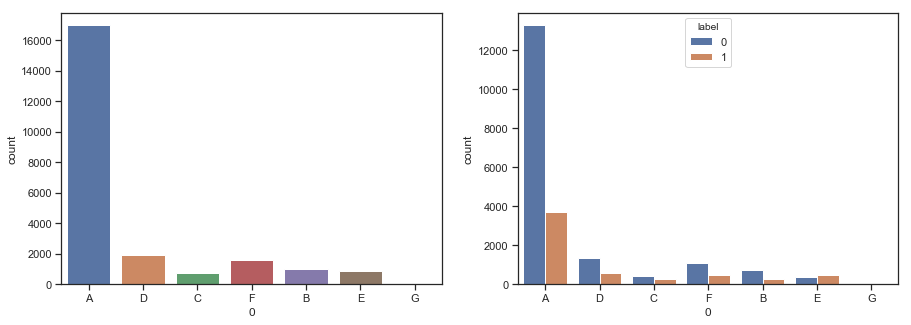

In [34]:
explor_func_graph('0')

____
### Feature '1'

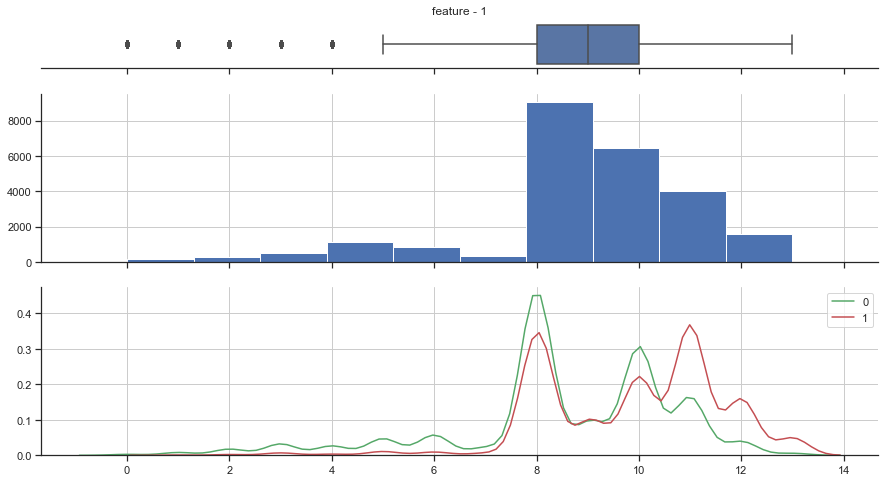

In [37]:
explor_func_graph('1')

____
### Feature '2'

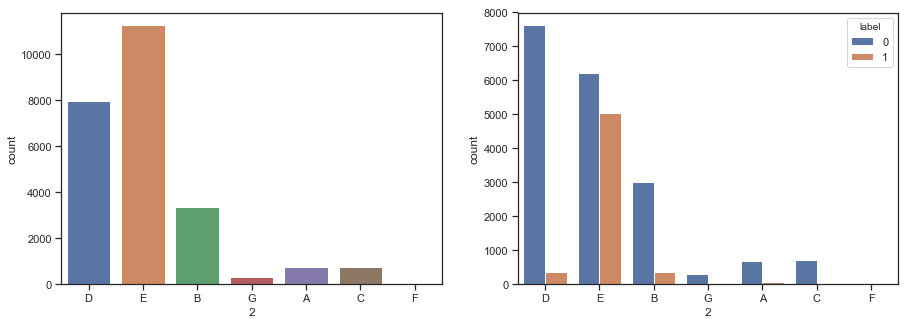

In [38]:
explor_func_graph('2')

____
### Feature '3'

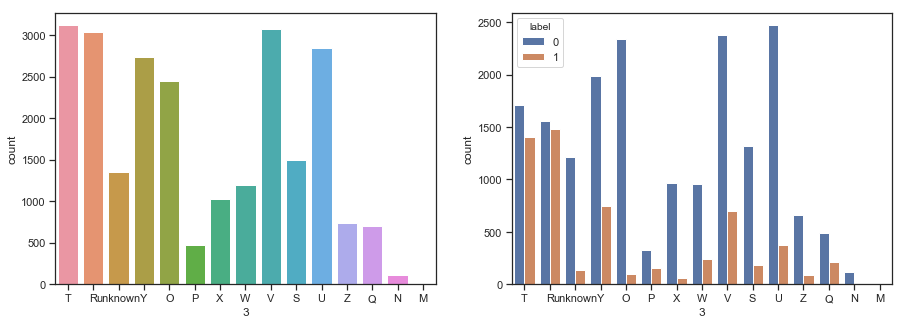

In [39]:
explor_func_graph('3')

____
### Feature '4'

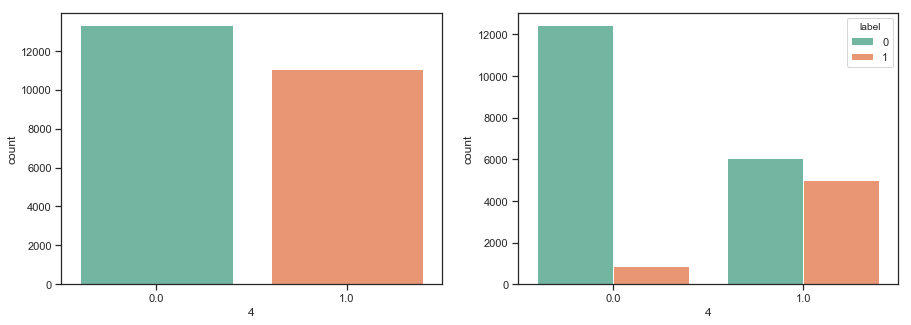

In [40]:
explor_func_graph('4')

____
### Feature '5'

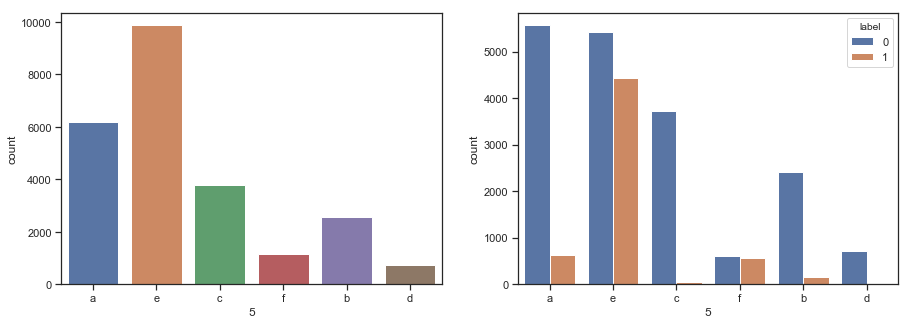

In [41]:
explor_func_graph('5')

____
### Feature '6'

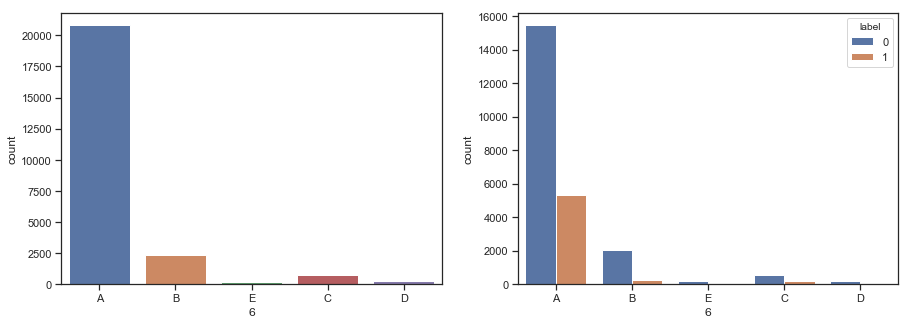

In [42]:
explor_func_graph('6')

____
### Feature '7'

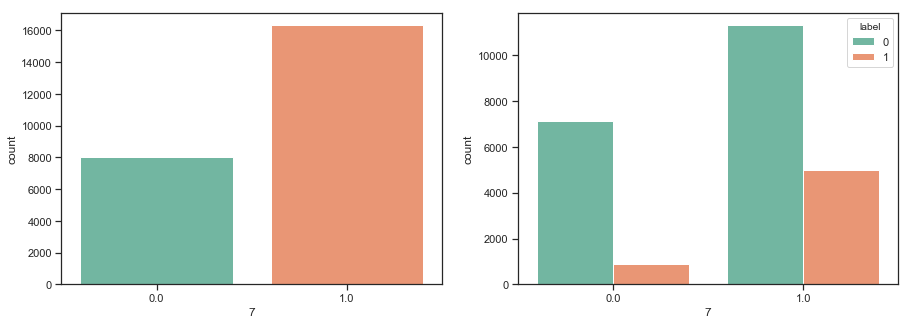

In [43]:
explor_func_graph('7')

____
### Feature '8'

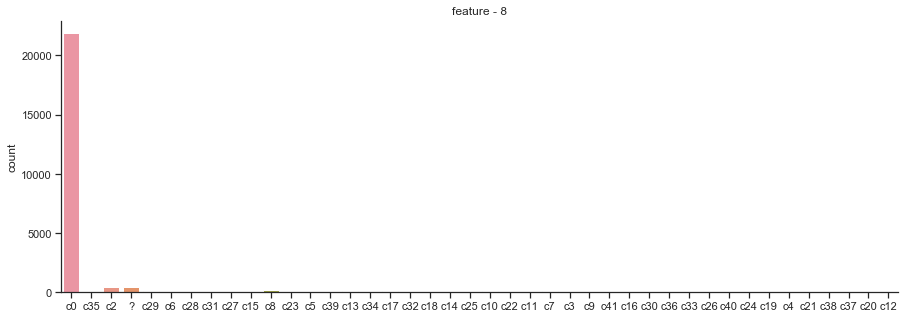

In [44]:
explor_func_graph('8')

____
### Feature '9'

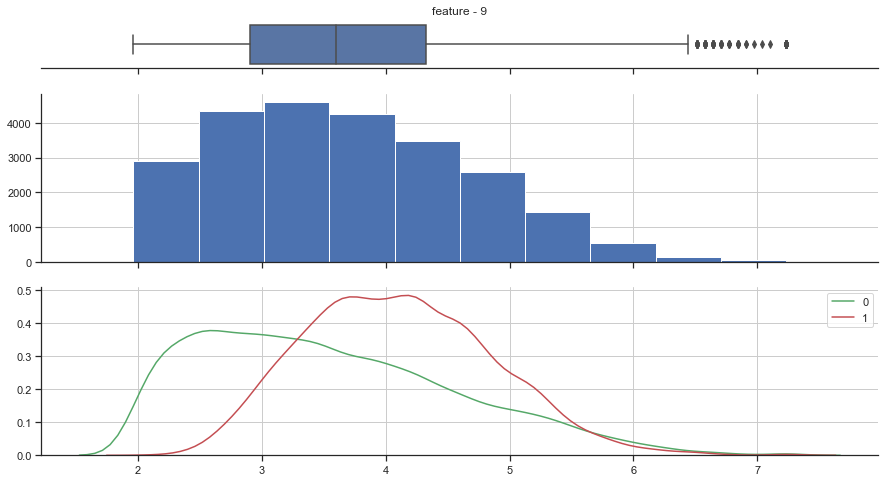

In [45]:
explor_func_graph('9')

____
### Feature '10'

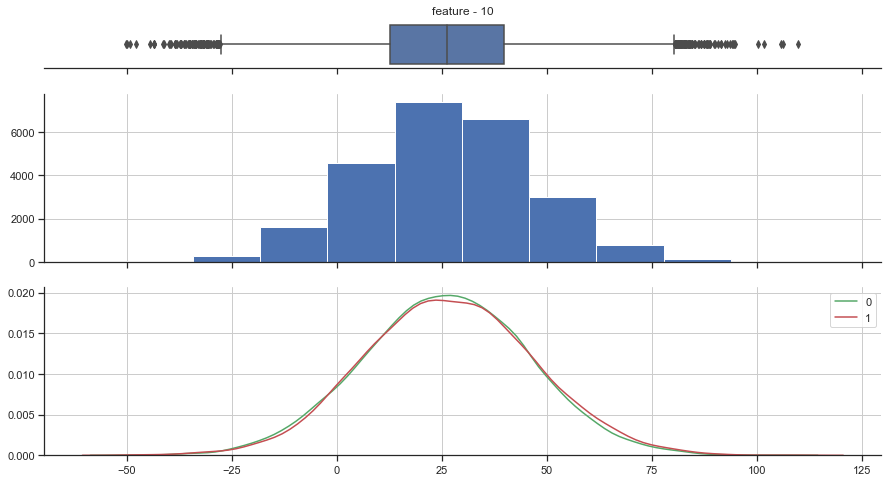

In [46]:
explor_func_graph('10')

____
### Feature '11'

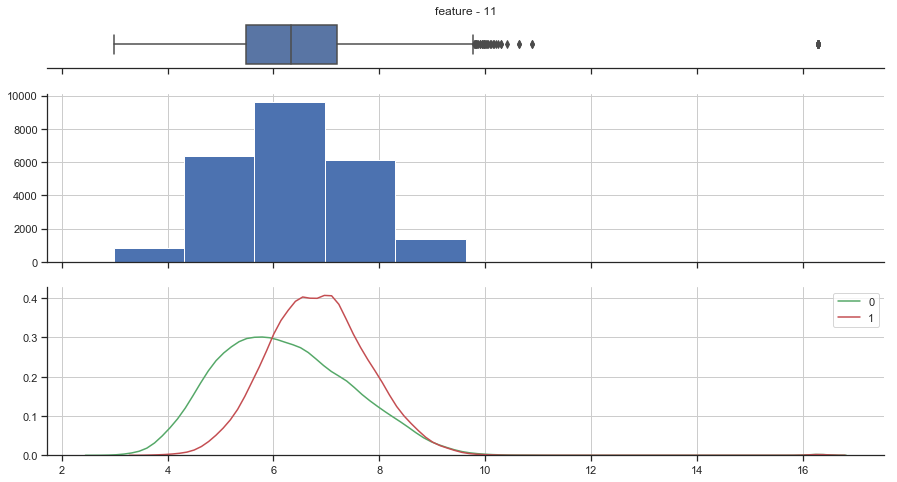

In [47]:
explor_func_graph('11')

____
### Feature '12'

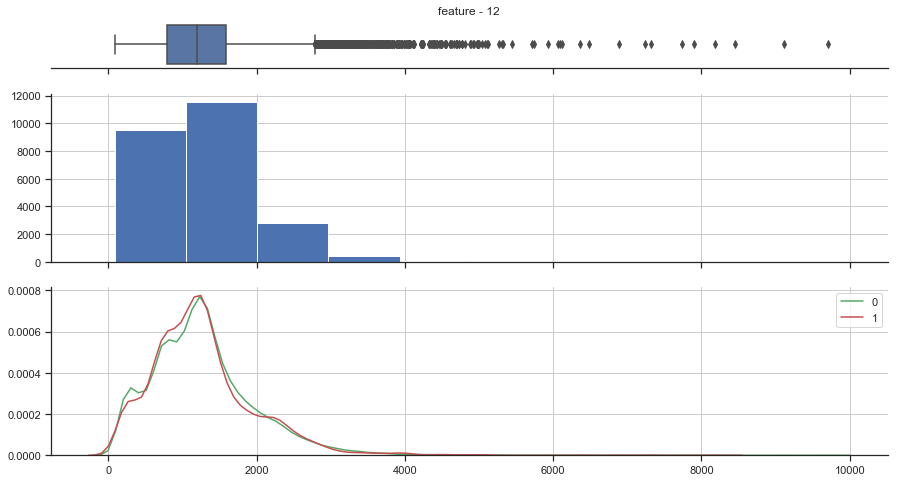

In [48]:
explor_func_graph('12')

____
### Feature '13'

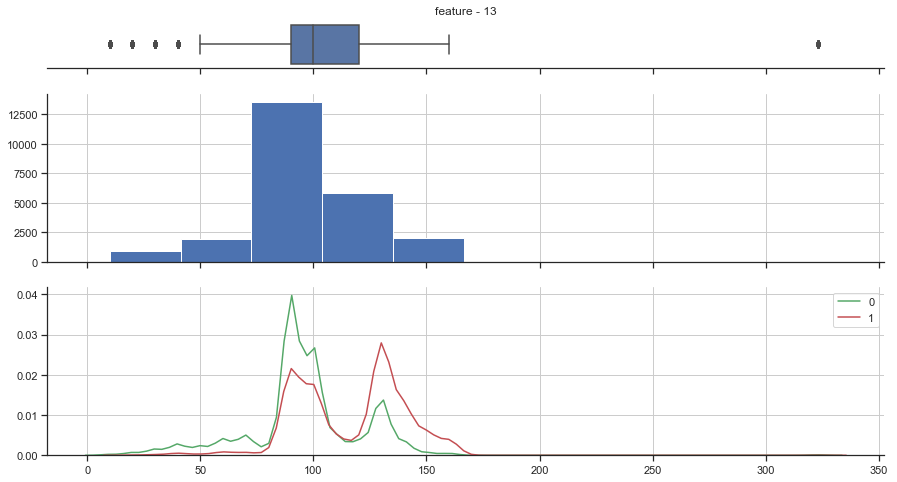

In [49]:
explor_func_graph('13')

____
### Feature '14'

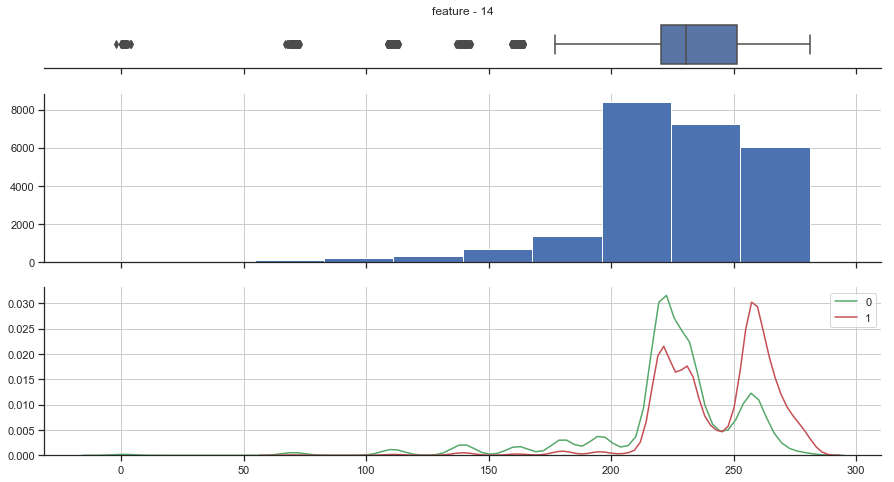

In [50]:
explor_func_graph('14')

____
### Feature '15'

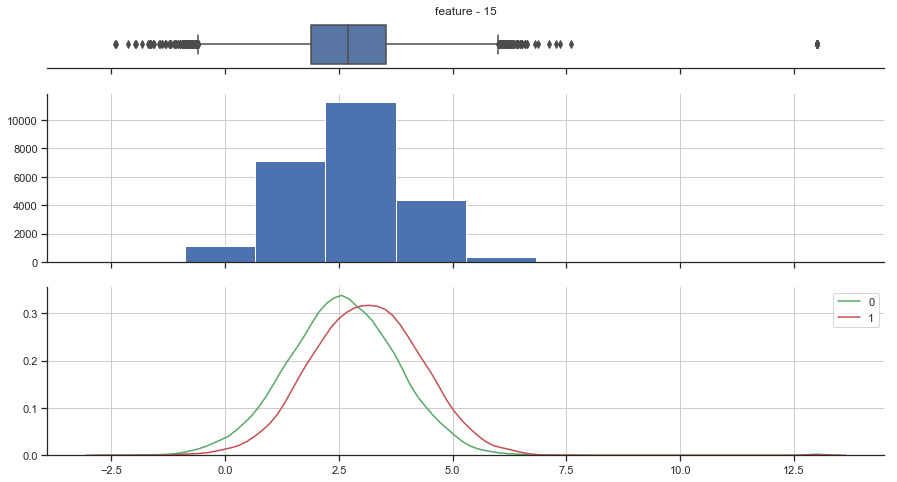

In [51]:
explor_func_graph('15')

____
### Feature '16'

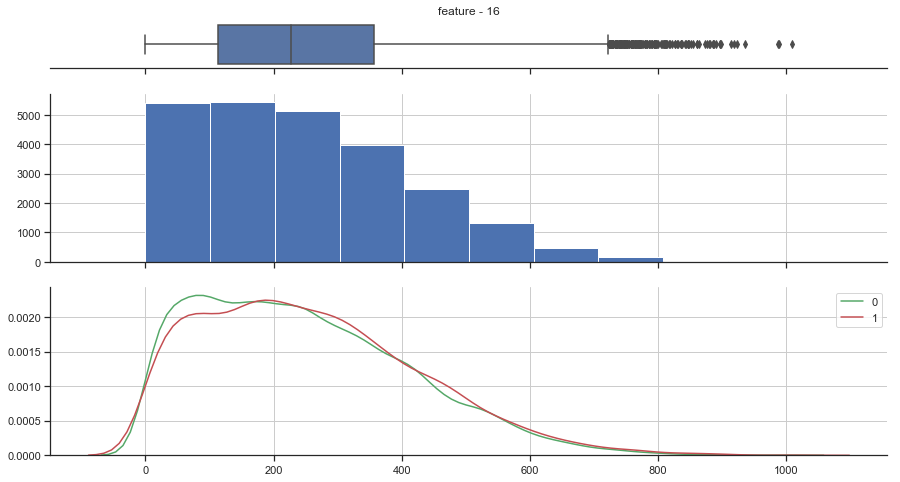

In [52]:
explor_func_graph('16')

____
### Feature '17'

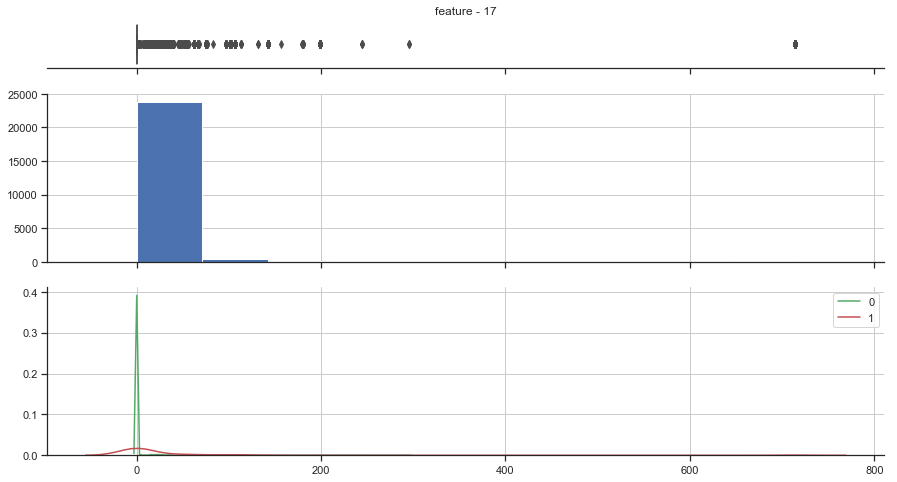

In [53]:
explor_func_graph('17')

____
### Feature '18'

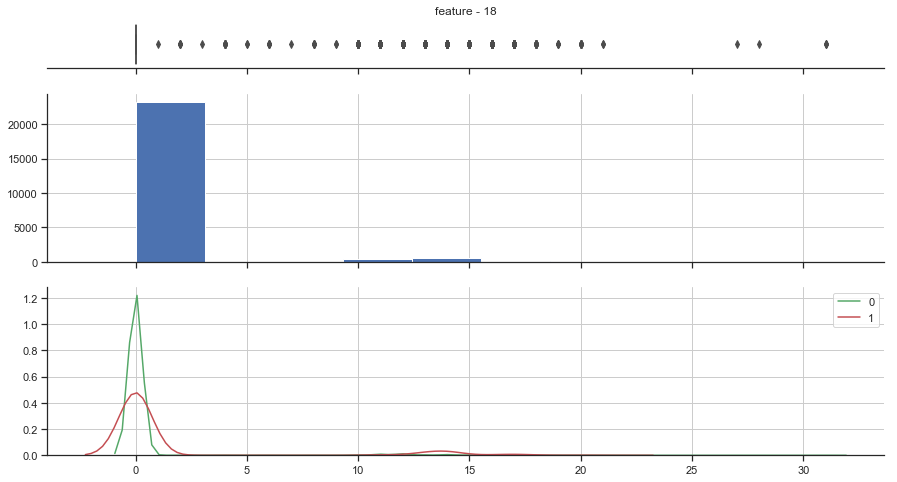

In [54]:
explor_func_graph('18')

____
### Feature '19'

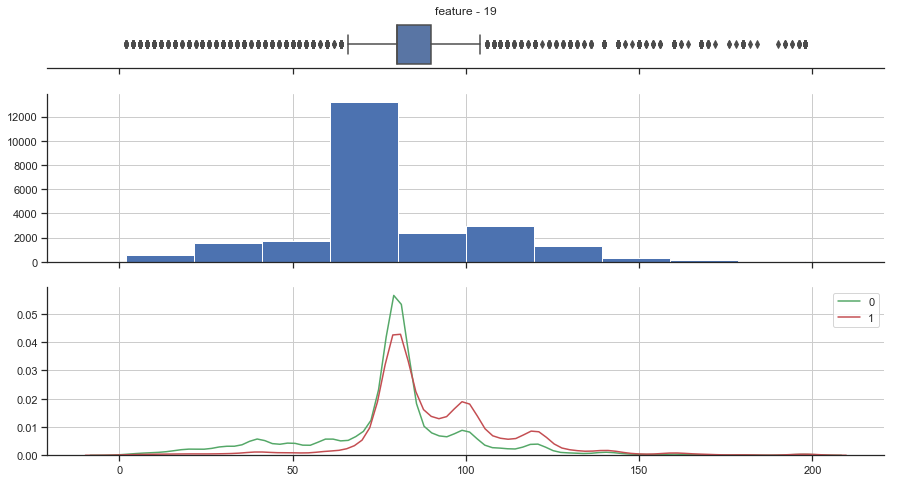

In [55]:
explor_func_graph('19')

____
### Feature '20'

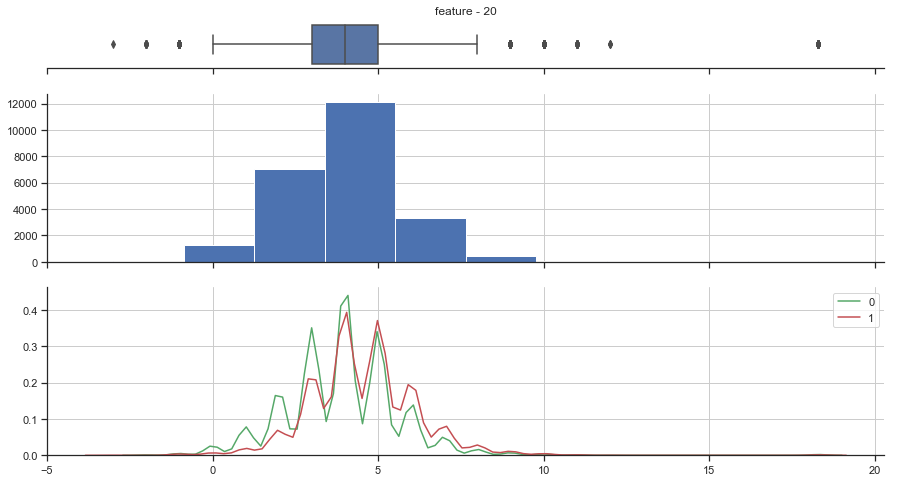

In [56]:
explor_func_graph('20')

____
### Label

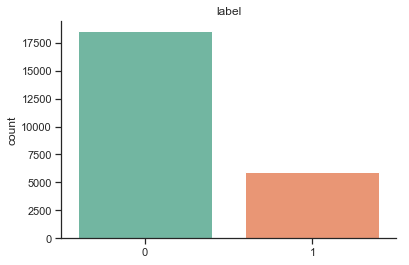

In [59]:
explor_func_graph('label')

_______________________

## Feature correlations

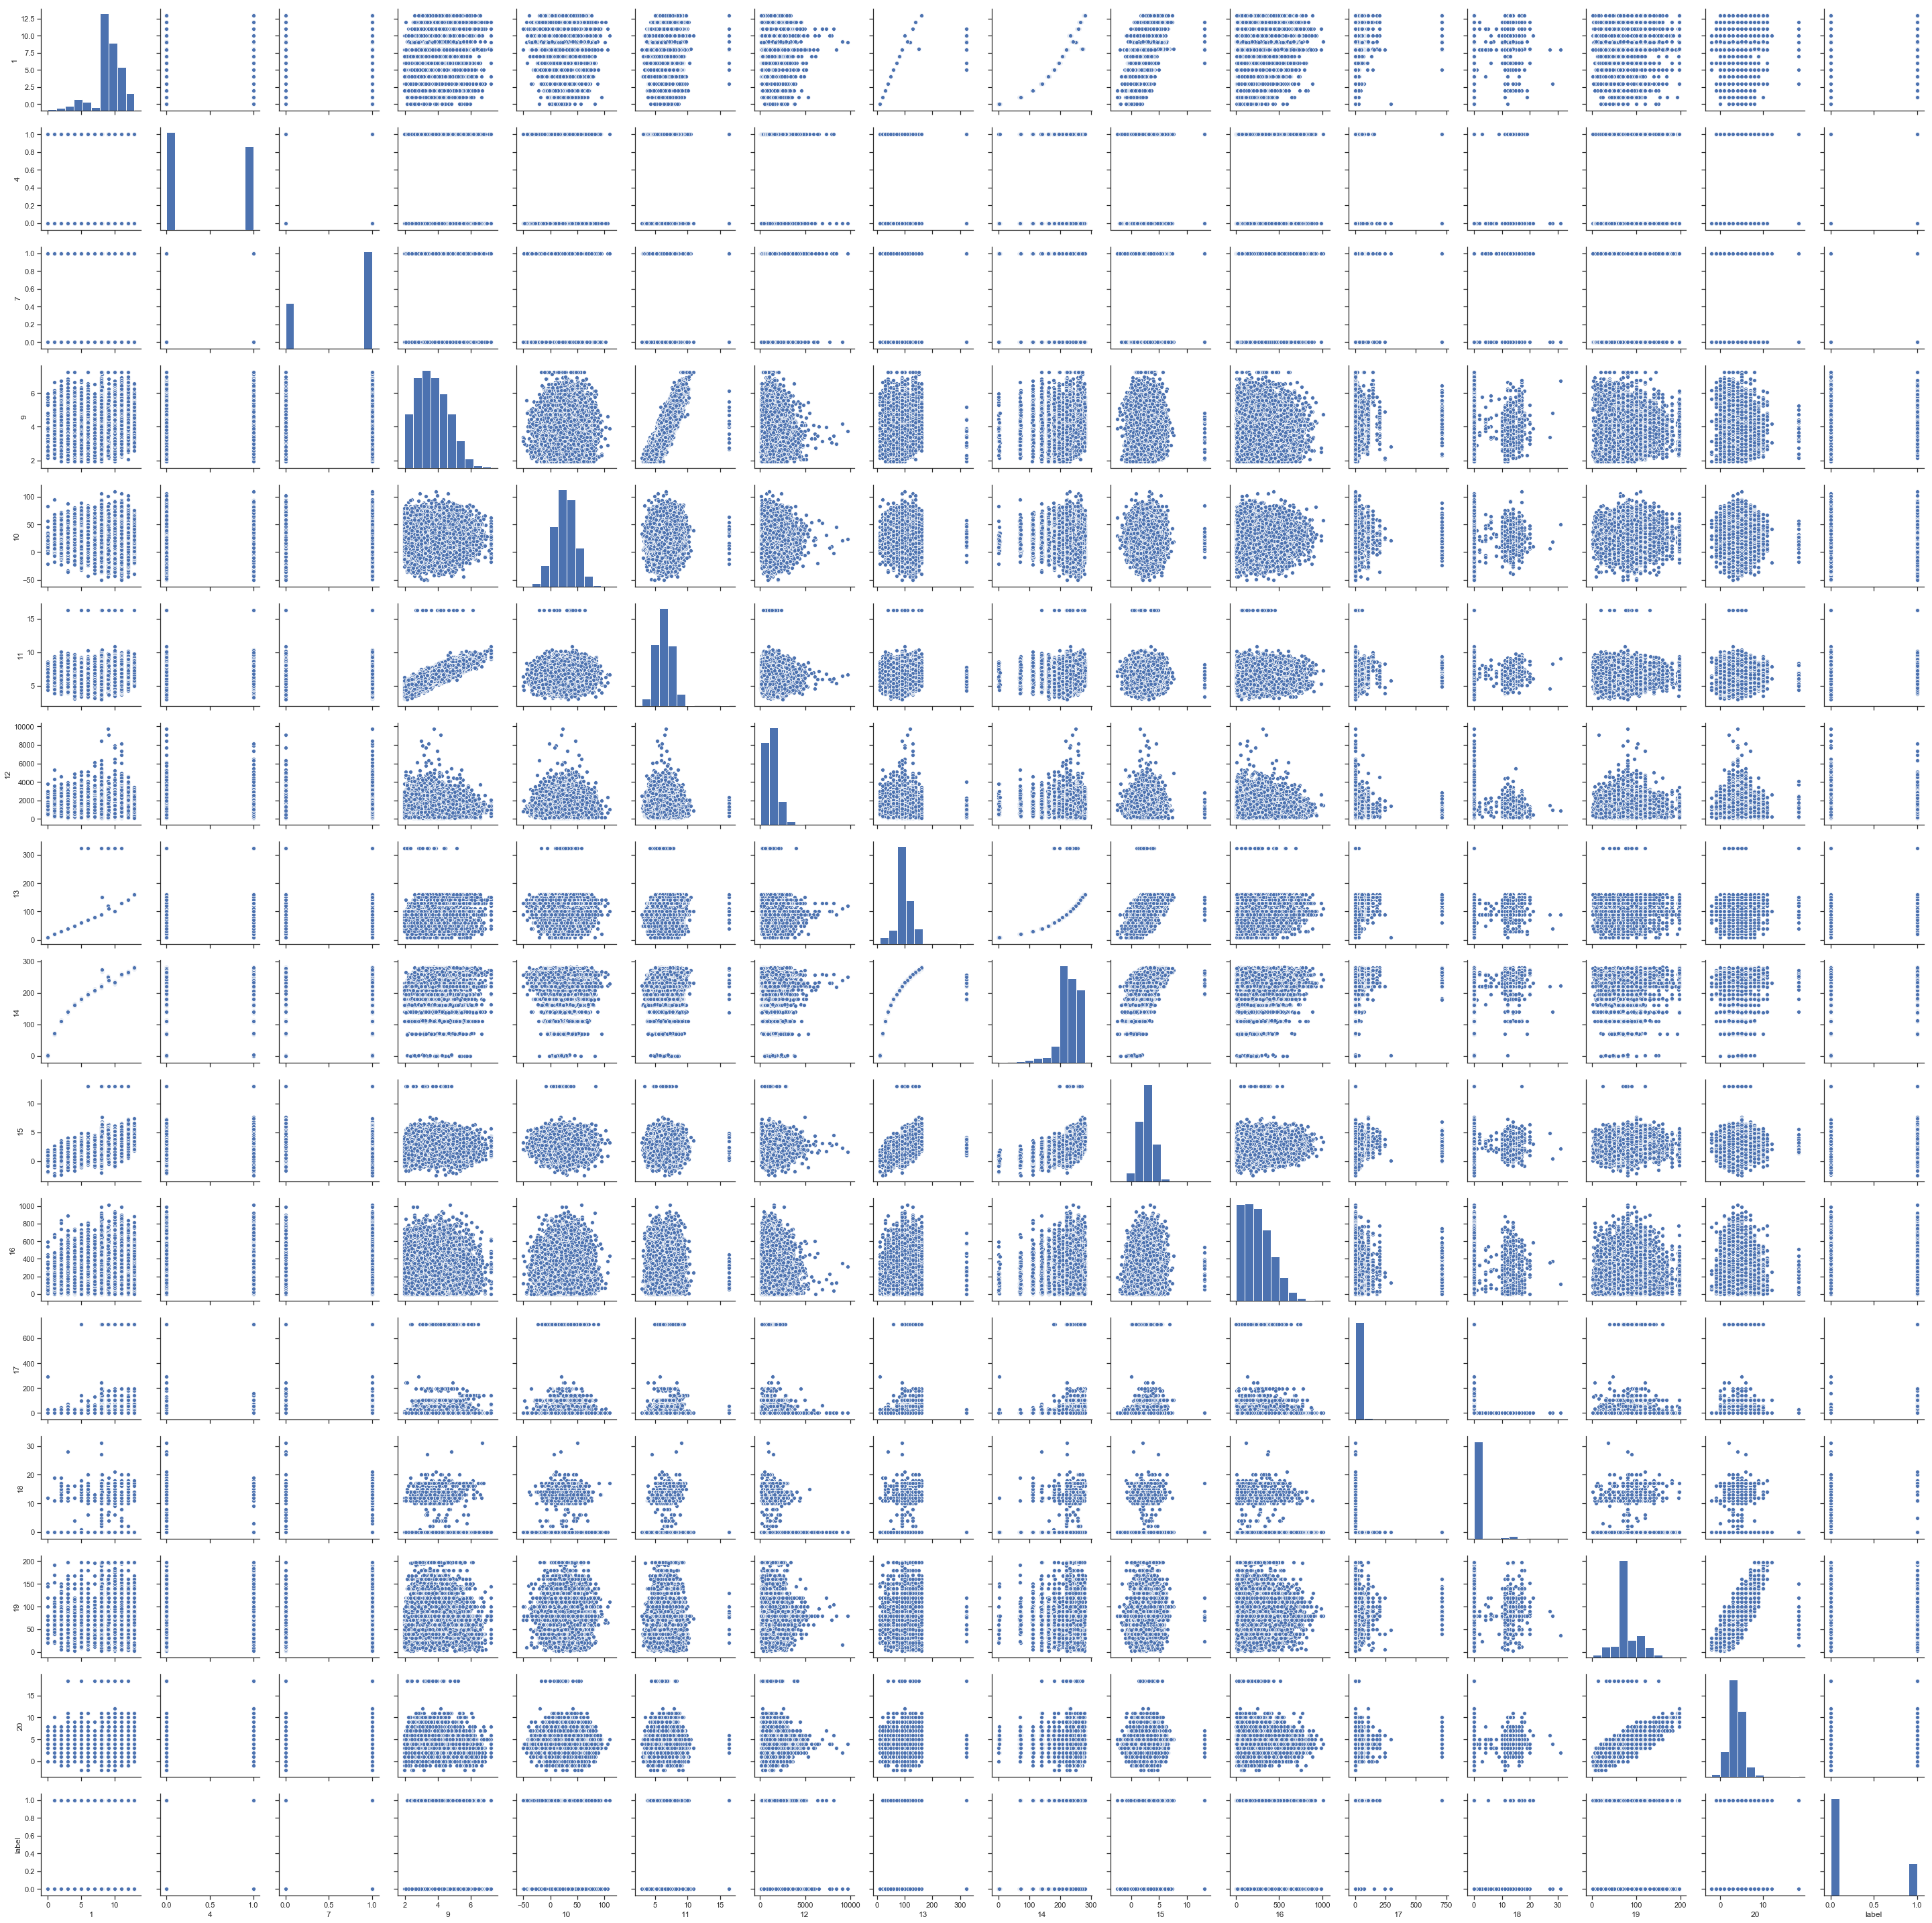

In [61]:
sns.pairplot(df.dropna());

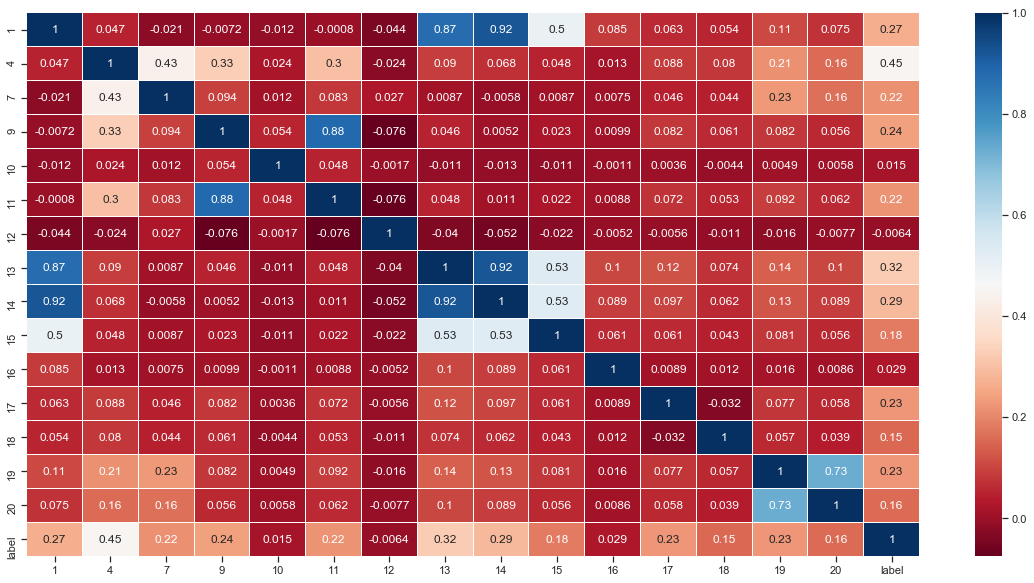

In [62]:
plt.figure(figsize=(20,10))
sns.heatmap(
    df.corr(),
    xticklabels=df.corr().columns.values,
    yticklabels=df.corr().columns.values,
    annot=True,
    linecolor='white',
    linewidths=0.1,
    cmap="RdBu"
)
plt.show()

**Let's see NaN values**

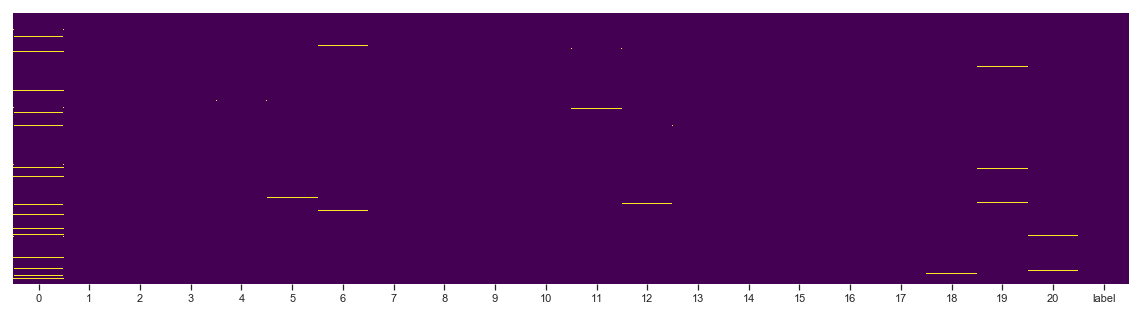

In [63]:
plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis');

___________________________________________

# 2. Preprocessing

**After we saw the graphs lets check the values in every feature and decide what to do**

### Feature - 0

In [64]:
df['0'].value_counts(dropna = False)

A      16974
D       1909
F       1572
NaN     1413
B        984
E        842
C        715
G         11
Name: 0, dtype: int64

**Lets change categorical feature - '0' to binary feature 'A0' <br>
We will not drop NaN in feature - '0', we will just put 0 instead because we don't want to lose data**

In [65]:
df['0']=[1 if i=='A' else 0 for i in df['0']]
df.rename(columns={'0': 'A0'}, inplace = True)

In [66]:
df['A0'].value_counts()

1    16974
0     7446
Name: A0, dtype: int64

### Test set

In [67]:
df_test['0']=[1 if i=='A' else 0 for i in df_test['0']]
df_test.rename(columns={'0': 'A0'}, inplace = True)

___

### Feature - 1

In [68]:
df['1'].value_counts(dropna = False)

 8.0     7817
 10.0    5397
 11.0    4031
 12.0    1282
 9.1     1050
 6.0      858
 9.0      788
 5.0      721
 3.0      491
 8.1      447
 4.0      392
 7.0      336
 13.0     306
 2.0      259
 1.0      118
NaN        89
 0.0       38
Name: 1, dtype: int64

**replace NaN with mean value**

In [69]:
mean_1 = df['1'].mean()
df['1'].fillna(mean_1, inplace=True)
df['1'].isnull().sum()

0

### Test set

In [70]:
df_test['1'].fillna(mean_1, inplace=True)

In [71]:
df_test['1'].isnull().sum()

0

___

### Feature - 2

In [72]:
df['2'].value_counts(dropna = False)

E      11246
D       7968
B       3350
C        769
A        738
G        330
F         18
NaN        1
Name: 2, dtype: int64

**finding percentage of occupency**

In [73]:
freq_series = df['2'].value_counts(dropna = False)
freq_2 = (freq_series/freq_series.sum())*100
freq_2

E      46.052416
D      32.628993
B      13.718264
C       3.149058
A       3.022113
G       1.351351
F       0.073710
NaN     0.004095
Name: 2, dtype: float64

**lets replace low frequency categories with 'Other':  *C + A + G + F $\rightarrow $ Other_2* ( NaN also will be included in Other, because there is only 1 NaN here )**

In [74]:
mask_2 = ((freq_series/freq_series.sum())*100).lt(4)
df['2'] = np.where(df['2'].isin(freq_series[mask_2].index),'Other_2',df['2'])
mask_2

E      False
D      False
B      False
C       True
A       True
G       True
F       True
NaN     True
Name: 2, dtype: bool

In [75]:
df['2'].value_counts(dropna = False)

E          11246
D           7968
B           3350
Other_2     1856
Name: 2, dtype: int64

**lets use One Hot Encoding to create 4 new binary features**

In [76]:
feat_2_dummies = pd.get_dummies(df['2'])

In [77]:
feat_2_dummies.head(3)

B  D  E  Other_2
0  0  1  0        0
1  0  0  1        0
2  1  0  0        0

In [78]:
df.drop(['2'],axis=1,inplace = True)

In [79]:
df = pd.concat([df,feat_2_dummies],axis=1)

In [80]:
df.head(3)

A0     1  3    4  5  6    7   8         9         10        11  \
0   1   5.0  T  0.0  a  A  1.0  c0  3.669168   8.070319  6.834657   
1   1  11.0  T  1.0  e  A  1.0  c0  2.658162   4.058713  6.120013   
2   0  10.0  R  0.0  a  A  1.0  c0  5.437138  34.948770  9.145930   

            12     13          14        15          16   17    18     19  \
0  1169.066667   60.0  181.278476  1.653801  409.912263  0.0  18.0  180.0   
1   876.420000  130.0  256.966948  3.234822  259.659556  0.0   0.0   80.0   
2  1210.406667  100.0  231.301660  3.357442  637.323821  0.0   0.0  100.0   

     20  label  B  D  E  Other_2  
0  11.0      1  0  1  0        0  
1   3.0      0  0  0  1        0  
2   6.0      0  1  0  0        0

In [81]:
df.shape

(24420, 25)

### Test set

In [82]:
df_test['2'] = np.where(df_test['2'].isin(freq_series[mask_2].index),'Other_2',df_test['2'])

In [83]:
test_feat_2_dummies = pd.get_dummies(df_test['2'])
df_test.drop(['2'],axis=1,inplace = True)
df_test = pd.concat([df_test,test_feat_2_dummies],axis=1)

In [84]:
df_test.head(3)

A0     1  3    4  5  6    7   8         9         10        11  \
0   1  10.0  X  1.0  e  A  1.0  c0  2.980762  26.016737  5.894672   
1   1  10.0  Y  0.0  c  A  1.0  c0  2.143788   2.125067  4.609658   
2   1  10.0  Q  1.0  f  A  0.0  c0  2.901297 -26.346464  5.251290   

            12     13          14        15          16   17   18    19   20  \
0  1870.786667  100.0  235.202236  2.141704  543.785299  0.0  0.0  80.0  4.0   
1  2931.860000  100.0  232.877280  0.870279  177.284459  0.0  0.0  30.0  2.0   
2  1364.893333  100.0  232.246162  1.768367  102.037179  0.0  0.0  80.0  5.0   

   B  D  E  Other_2  
0  0  0  1        0  
1  0  1  0        0  
2  0  0  1        0

In [85]:
df_test.shape

(8141, 24)

___

### Feature - 3

In [86]:
df['3'].value_counts(dropna = False)

T          3117
V          3079
R          3040
U          2841
Y          2734
O          2445
S          1499
unknown    1353
W          1200
X          1024
Z           744
Q           706
P           478
N           114
NaN          39
M             7
Name: 3, dtype: int64

**first let's merge categories with low frequency into another new category "Other_3"<br>
*N + NaN + M  $\rightarrow $ Other_3***

In [87]:
freq_series = df['3'].value_counts(dropna = False)
(freq_series/freq_series.sum())*100

T          12.764128
V          12.608518
R          12.448812
U          11.633907
Y          11.195741
O          10.012285
S           6.138411
unknown     5.540541
W           4.914005
X           4.193284
Z           3.046683
Q           2.891073
P           1.957412
N           0.466830
NaN         0.159705
M           0.028665
Name: 3, dtype: float64

In [88]:
mask = ((freq_series/freq_series.sum())*100).lt(1)
df['3'] = np.where(df['3'].isin(freq_series[mask].index),'Other_3',df['3'])

**Now let's replace "unknown" as "UN" and leave it as a category**

In [89]:
df['3'].replace('unknown', 'UN', inplace = True)

**now lets try One-Hot Encoding as for recent feature ('2')**<br>
we will check our model in future and may be we'll need to use another way of encoding

In [90]:
feat_3_dummies = pd.get_dummies(df['3'])
df.drop(['3'],axis=1,inplace = True)
df = pd.concat([df,feat_3_dummies],axis=1)

In [91]:
df.head()

A0     1    4  5  6    7   8         9         10        11           12  \
0   1   5.0  0.0  a  A  1.0  c0  3.669168   8.070319  6.834657  1169.066667   
1   1  11.0  1.0  e  A  1.0  c0  2.658162   4.058713  6.120013   876.420000   
2   0  10.0  0.0  a  A  1.0  c0  5.437138  34.948770  9.145930  1210.406667   
3   0  11.0  0.0  a  A  1.0  c0  4.536484  21.944065  6.940558  1677.233333   
4   0  10.0  0.0  a  A  1.0  c0  2.491467  12.183163  4.787420   973.093333   

      13          14        15          16   17    18     19    20  label  B  \
0   60.0  181.278476  1.653801  409.912263  0.0  18.0  180.0  11.0      1  0   
1  130.0  256.966948  3.234822  259.659556  0.0   0.0   80.0   3.0      0  0   
2  100.0  231.301660  3.357442  637.323821  0.0   0.0  100.0   6.0      0  1   
3  130.0  256.867858  3.127544  271.138934  0.0   0.0  110.0   5.0      1  1   
4  100.0  229.547530  2.156058  174.691072  0.0   0.0   80.0   4.0      0  0   

   D  E  Other_2  O  Other_3  P  Q  R  S  T  U  UN  V  W  X  Y  Z  
0  1  0        0  0        0  0  0  0  0  1  0   0  0  0  0  0  0  
1  0  1        0  0        0  0  0  0  0  1  0   0  0  0  0  0  0  
2  0  0        0  0        0  0  0  1  0  0  0   0  0  0  0  0  0  
3  0  0        0  0        0  0  0  1  0  0  0   0  0  0  0  0  0  
4  1  0        0  0        0  0  0  0  0  0  0   1  0  0  0  0  0

### Test set

In [92]:
df_test['3'] = np.where(df_test['3'].isin(freq_series[mask].index),'Other_3',df_test['3'])

In [93]:
df_test['3'].replace('unknown', 'UN', inplace = True)

In [94]:
feat_3_dummies = pd.get_dummies(df_test['3'])
df_test.drop(['3'],axis=1,inplace = True)
df_test = pd.concat([df_test,feat_3_dummies],axis=1)

In [95]:
df_test.head(2)

A0     1    4  5  6    7   8         9         10        11           12  \
0   1  10.0  1.0  e  A  1.0  c0  2.980762  26.016737  5.894672  1870.786667   
1   1  10.0  0.0  c  A  1.0  c0  2.143788   2.125067  4.609658  2931.860000   

      13          14        15          16   17   18    19   20  B  D  E  \
0  100.0  235.202236  2.141704  543.785299  0.0  0.0  80.0  4.0  0  0  1   
1  100.0  232.877280  0.870279  177.284459  0.0  0.0  30.0  2.0  0  1  0   

   Other_2  O  Other_3  P  Q  R  S  T  U  UN  V  W  X  Y  Z  
0        0  0        0  0  0  0  0  0  0   0  0  0  1  0  0  
1        0  0        0  0  0  0  0  0  0   0  0  0  0  1  0

___

### Feature - 5

In [96]:
df['5'].value_counts(dropna = False)

e      9864
a      6191
c      3778
b      2573
f      1172
d       740
NaN     102
Name: 5, dtype: int64

In [97]:
freq_series_5 = df['5'].value_counts(dropna = False)
(freq_series_5/freq_series_5.sum())*100

e      40.393120
a      25.352170
c      15.470925
b      10.536446
f       4.799345
d       3.030303
NaN     0.417690
Name: 5, dtype: float64

***NaN + d  $\rightarrow $ Other_5***

In [98]:
mask_5 = ((freq_series_5/freq_series_5.sum())*100).lt(4)
df['5'] = np.where(df['5'].isin(freq_series_5[mask_5].index),'Other_5',df['5'])

In [99]:
df['5'].value_counts(dropna = False)

e          9864
a          6191
c          3778
b          2573
f          1172
Other_5     842
Name: 5, dtype: int64

**One Hot Encoding**

In [100]:
feat_5_dummies = pd.get_dummies(df['5'])
df.drop(['5'],axis=1,inplace = True)
df = pd.concat([df,feat_5_dummies],axis=1)

In [101]:
df.head(2)

A0     1    4  6    7   8         9        10        11           12  \
0   1   5.0  0.0  A  1.0  c0  3.669168  8.070319  6.834657  1169.066667   
1   1  11.0  1.0  A  1.0  c0  2.658162  4.058713  6.120013   876.420000   

      13          14        15          16   17    18     19    20  label  B  \
0   60.0  181.278476  1.653801  409.912263  0.0  18.0  180.0  11.0      1  0   
1  130.0  256.966948  3.234822  259.659556  0.0   0.0   80.0   3.0      0  0   

   D  E  Other_2  O  Other_3  P  Q  R  S  T  U  UN  V  W  X  Y  Z  Other_5  a  \
0  1  0        0  0        0  0  0  0  0  1  0   0  0  0  0  0  0        0  1   
1  0  1        0  0        0  0  0  0  0  1  0   0  0  0  0  0  0        0  0   

   b  c  e  f  
0  0  0  0  0  
1  0  0  1  0

In [102]:
df.shape

(24420, 43)

### Test set

In [103]:
df_test['5'] = np.where(df_test['5'].isin(freq_series_5[mask_5].index),'Other_5',df_test['5'])

In [104]:
test_feat_5_dummies = pd.get_dummies(df_test['5'])
df_test.drop(['5'],axis=1,inplace = True)
df_test = pd.concat([df_test,test_feat_5_dummies],axis=1)

In [105]:
df_test.head(2)

A0     1    4  6    7   8         9         10        11           12  \
0   1  10.0  1.0  A  1.0  c0  2.980762  26.016737  5.894672  1870.786667   
1   1  10.0  0.0  A  1.0  c0  2.143788   2.125067  4.609658  2931.860000   

      13          14        15          16   17   18    19   20  B  D  E  \
0  100.0  235.202236  2.141704  543.785299  0.0  0.0  80.0  4.0  0  0  1   
1  100.0  232.877280  0.870279  177.284459  0.0  0.0  30.0  2.0  0  1  0   

   Other_2  O  Other_3  P  Q  R  S  T  U  UN  V  W  X  Y  Z  Other_5  a  b  c  \
0        0  0        0  0  0  0  0  0  0   0  0  0  1  0  0        0  0  0  0   
1        0  0        0  0  0  0  0  0  0   0  0  0  0  1  0        0  0  0  1   

   e  f  
0  1  0  
1  0  0

In [106]:
df_test.shape

(8141, 42)

___

### Feature - 6

In [107]:
df['6'].value_counts(dropna = False)

A      20795
B       2341
C        786
D        229
E        202
NaN       67
Name: 6, dtype: int64

In [108]:
freq_series = df['6'].value_counts(dropna = False)
(freq_series/freq_series.sum())*100

A      85.155610
B       9.586405
C       3.218673
D       0.937756
E       0.827191
NaN     0.274365
Name: 6, dtype: float64

***C + D + E + NaN  $\rightarrow $ Other_6***

In [109]:
mask = ((freq_series/freq_series.sum())*100).lt(4)
df['6'] = np.where(df['6'].isin(freq_series[mask].index),'Other_6',df['6'])

In [110]:
df['6'].replace('A', 'A6', inplace = True)
df['6'].replace('B', 'B6', inplace = True)

In [111]:
df['6'].value_counts(dropna = False)

A6         20795
B6          2341
Other_6     1284
Name: 6, dtype: int64

**One Hot Encoding**

In [112]:
feat_6_dummies = pd.get_dummies(df['6'])
df.drop(['6'],axis=1,inplace = True)
df = pd.concat([df,feat_6_dummies],axis=1)

In [113]:
df.head(3)

A0     1    4    7   8         9         10        11           12     13  \
0   1   5.0  0.0  1.0  c0  3.669168   8.070319  6.834657  1169.066667   60.0   
1   1  11.0  1.0  1.0  c0  2.658162   4.058713  6.120013   876.420000  130.0   
2   0  10.0  0.0  1.0  c0  5.437138  34.948770  9.145930  1210.406667  100.0   

           14        15          16   17    18     19    20  label  B  D  E  \
0  181.278476  1.653801  409.912263  0.0  18.0  180.0  11.0      1  0  1  0   
1  256.966948  3.234822  259.659556  0.0   0.0   80.0   3.0      0  0  0  1   
2  231.301660  3.357442  637.323821  0.0   0.0  100.0   6.0      0  1  0  0   

   Other_2  O  Other_3  P  Q  R  S  T  U  UN  V  W  X  Y  Z  Other_5  a  b  c  \
0        0  0        0  0  0  0  0  1  0   0  0  0  0  0  0        0  1  0  0   
1        0  0        0  0  0  0  0  1  0   0  0  0  0  0  0        0  0  0  0   
2        0  0        0  0  0  1  0  0  0   0  0  0  0  0  0        0  1  0  0   

   e  f  A6  B6  Other_6  
0  0  0   1   0        0  
1  1  0   1   0        0  
2  0  0   1   0        0

In [114]:
df.shape

(24420, 45)

### Test set

In [115]:
df_test['6'] = np.where(df_test['6'].isin(freq_series[mask].index),'Other_6',df_test['6'])

In [116]:
df_test['6'].replace('A', 'A6', inplace = True)
df_test['6'].replace('B', 'B6', inplace = True)

In [117]:
feat_6_dummies = pd.get_dummies(df_test['6'])
df_test.drop(['6'],axis=1,inplace = True)
df_test = pd.concat([df_test,feat_6_dummies],axis=1)

In [118]:
df_test.head(2)

A0     1    4    7   8         9         10        11           12     13  \
0   1  10.0  1.0  1.0  c0  2.980762  26.016737  5.894672  1870.786667  100.0   
1   1  10.0  0.0  1.0  c0  2.143788   2.125067  4.609658  2931.860000  100.0   

           14        15          16   17   18    19   20  B  D  E  Other_2  O  \
0  235.202236  2.141704  543.785299  0.0  0.0  80.0  4.0  0  0  1        0  0   
1  232.877280  0.870279  177.284459  0.0  0.0  30.0  2.0  0  1  0        0  0   

   Other_3  P  Q  R  S  T  U  UN  V  W  X  Y  Z  Other_5  a  b  c  e  f  A6  \
0        0  0  0  0  0  0  0   0  0  0  1  0  0        0  0  0  0  1  0   1   
1        0  0  0  0  0  0  0   0  0  0  0  1  0        0  0  0  1  0  0   1   

   B6  Other_6  
0   0        0  
1   0        0

In [119]:
df_test.shape

(8141, 44)

___

### Feature - 8

In [120]:
df['8'].value_counts(dropna = False)

c0     21850
c2       482
?        452
c8       155
c17      112
c10       92
c29       89
c13       80
c7        75
c16       66
c22       64
c11       63
c5        61
c33       55
c18       54
c31       52
c27       52
c4        50
c32       47
c19       42
c14       41
c6        37
c15       32
c28       30
c38       28
c26       28
c35       26
c25       26
c3        22
c34       17
c20       15
c24       15
c36       14
c40       14
c23       13
c39       13
c9        12
c41       12
c30       11
c37       10
c21        7
NaN        3
c12        1
Name: 8, dtype: int64

**first lets fill missing value "?" with c0, because it most frequent**

In [121]:
df['8'].replace('?', 'c0', inplace = True)

In [122]:
df['8'].value_counts().head()

c0     22302
c2       482
c8       155
c17      112
c10       92
Name: 8, dtype: int64

**now lets create binary feature c0 instaed**

In [123]:
df['8']=[1 if i=='c0' else 0 for i in df['8']]
df.rename(columns={'8': 'c0'}, inplace=True)

In [124]:
df.head(3)

A0     1    4    7  c0         9         10        11           12     13  \
0   1   5.0  0.0  1.0   1  3.669168   8.070319  6.834657  1169.066667   60.0   
1   1  11.0  1.0  1.0   1  2.658162   4.058713  6.120013   876.420000  130.0   
2   0  10.0  0.0  1.0   1  5.437138  34.948770  9.145930  1210.406667  100.0   

           14        15          16   17    18     19    20  label  B  D  E  \
0  181.278476  1.653801  409.912263  0.0  18.0  180.0  11.0      1  0  1  0   
1  256.966948  3.234822  259.659556  0.0   0.0   80.0   3.0      0  0  0  1   
2  231.301660  3.357442  637.323821  0.0   0.0  100.0   6.0      0  1  0  0   

   Other_2  O  Other_3  P  Q  R  S  T  U  UN  V  W  X  Y  Z  Other_5  a  b  c  \
0        0  0        0  0  0  0  0  1  0   0  0  0  0  0  0        0  1  0  0   
1        0  0        0  0  0  0  0  1  0   0  0  0  0  0  0        0  0  0  0   
2        0  0        0  0  0  1  0  0  0   0  0  0  0  0  0        0  1  0  0   

   e  f  A6  B6  Other_6  
0  0  0   1   0        0  
1  1  0   1   0        0  
2  0  0   1   0        0

In [125]:
df.shape

(24420, 45)

### Test set

In [126]:
df_test['8'].replace('?', 'c0', inplace = True)

In [127]:
df_test['8']=[1 if i=='c0' else 0 for i in df_test['8']]
df_test.rename(columns={'8': 'c0'}, inplace=True)

In [128]:
df_test.head(2)

A0     1    4    7  c0         9         10        11           12     13  \
0   1  10.0  1.0  1.0   1  2.980762  26.016737  5.894672  1870.786667  100.0   
1   1  10.0  0.0  1.0   1  2.143788   2.125067  4.609658  2931.860000  100.0   

           14        15          16   17   18    19   20  B  D  E  Other_2  O  \
0  235.202236  2.141704  543.785299  0.0  0.0  80.0  4.0  0  0  1        0  0   
1  232.877280  0.870279  177.284459  0.0  0.0  30.0  2.0  0  1  0        0  0   

   Other_3  P  Q  R  S  T  U  UN  V  W  X  Y  Z  Other_5  a  b  c  e  f  A6  \
0        0  0  0  0  0  0  0   0  0  0  1  0  0        0  0  0  0  1  0   1   
1        0  0  0  0  0  0  0   0  0  0  0  1  0        0  0  0  1  0  0   1   

   B6  Other_6  
0   0        0  
1   0        0

In [129]:
df_test.shape

(8141, 44)

___

### Feature - 9

**As wee saw, this feature contains of continuous variables, so let replace NaN values with mean value ( same for 10,11,12,13,14,15,16,19 and 20 )**

In [130]:
mean_9 = df['9'].mean()

In [131]:
df['9'].fillna(mean_9, inplace=True)
df['9'].isnull().sum()

0

### Test set

In [132]:
df_test['9'].fillna(mean_9, inplace=True)
df_test['9'].isnull().sum()

0

___

### Feature - 10

In [133]:
mean_10 = df['10'].mean()

In [134]:
df['10'].fillna(mean_10, inplace=True)
df['10'].isnull().sum()

0

### Test set

In [135]:
df_test['10'].fillna(mean_10, inplace=True)
df_test['10'].isnull().sum()

0

___

### Feature - 11

In [136]:
mean_11 = df['11'].mean()

In [137]:
df['11'].fillna(mean_11, inplace=True)
df['11'].isnull().sum()

0

### Test set

In [138]:
df_test['11'].fillna(mean_11, inplace=True)
df_test['11'].isnull().sum()

0

___

### Feature - 12

In [139]:
mean_12 = df['12'].mean()

In [140]:
df['12'].fillna(mean_12, inplace=True)
df['12'].isnull().sum()

0

### Test set

In [141]:
df_test['12'].fillna(mean_12, inplace=True)
df_test['12'].isnull().sum()

0

___

### Feature - 13

In [142]:
mean_13 = df['13'].mean()

In [143]:
df['13'].fillna(mean_13, inplace=True)
df['13'].isnull().sum()

0

### Test set

In [144]:
df_test['13'].fillna(mean_13, inplace=True)
df_test['13'].isnull().sum()

0

___

### Feature - 14

In [145]:
mean_14 = df['14'].mean()

In [146]:
df['14'].fillna(mean_14, inplace=True)
df['14'].isnull().sum()

0

### Test set

In [147]:
df_test['14'].fillna(mean_14, inplace=True)
df_test['14'].isnull().sum()

0

___

### Feature - 15

In [148]:
mean_15 = df['15'].mean()

In [149]:
df['15'].fillna(mean_15, inplace=True)
df['15'].isnull().sum()

0

### Test set

In [150]:
df_test['15'].fillna(mean_15, inplace=True)
df_test['15'].isnull().sum()

0

___

### Feature - 16

In [151]:
mean_16 = df['16'].mean()

In [152]:
df['16'].fillna(mean_16, inplace=True)
df['16'].isnull().sum()

0

### Test set

In [153]:
df_test['16'].fillna(mean_16, inplace=True)
df_test['16'].isnull().sum()

0

___

### Feature - 19

In [154]:
mean_19 = df['19'].mean()

In [155]:
df['19'].fillna(mean_19, inplace=True)
df['19'].isnull().sum()

0

### Test set

In [156]:
df_test['19'].fillna(mean_19, inplace=True)
df_test['19'].isnull().sum()

0

___

### Feature - 20

In [157]:
mean_20 = df['20'].mean()

In [158]:
df['20'].fillna(mean_20, inplace=True)
df['20'].isnull().sum()

0

### Test set

In [159]:
df_test['20'].fillna(mean_20, inplace=True)
df_test['20'].isnull().sum()

0

___

### As we saw before in features 17 and 18, there are more than 90% values is ZEROS, we will log transform them and input mean of logtransformed values into NaN values

### Feature - 17

In [160]:
df['17'] = np.log(df['17']+3)

In [161]:
mean_17 = np.log(df['17']+3).mean()
df['17'].fillna(mean_17,inplace = True)

Here we tryied to make this features binary by precentage of non zeros values, but got a lower performance than log transform ( same for feature 18 )

In [162]:
# df[df['17']!=0.0]['17'].value_counts().sum()/df[df['17']==0.0]['17'].value_counts().sum()
# df['17']=[0 if i==0.0 else 1 for i in df['17']]
# df['17'].value_counts(dropna = False)

### Test set

In [163]:
df_test['17'] = np.log(df_test['17']+3)

In [164]:
df_test['17'].fillna(mean_17,inplace = True)

In [165]:
#df_test['17']=[0 if i==0.0 else 1 for i in df_test['17']]

___

### Feature - 18

In [166]:
df['18']= np.log(df['18']+5)

In [167]:
mean_18 = np.log(df['18']+5).mean()
df['18'].fillna(mean_18,inplace = True)

In [168]:
#df[df['18']!=0.0]['18'].value_counts().sum()/df[df['18']==0.0]['18'].value_counts().sum()

In [169]:
# df['18']=[0 if i==0.0 else 1 for i in df['18']]
# df['18'].value_counts(dropna = False)

### Test set

In [170]:
df_test['18'] = np.log(df_test['18']+5)

In [171]:
df_test['18'].fillna(mean_18,inplace = True)

In [172]:
# df_test['18']=[0 if i==0.0 else 1 for i in df_test['18']]

___

### Feature - 4

In [173]:
df['4'].value_counts(dropna = False)

 0.0    13306
 1.0    11069
NaN        45
Name: 4, dtype: int64

**Feature 4 has 55% of zeros and 45% of ones, so let's fill NaNs with last valid observation**

In [174]:
df['4'].fillna(method ='ffill', inplace = True)

In [175]:
df['4'].value_counts(dropna = False)

0.0    13330
1.0    11090
Name: 4, dtype: int64

Here we tryied to fill NaN with zeros and got lower perfomance

In [176]:
#df['4'].fillna(value = 0.0, inplace = True)

### Test set

In [177]:
df_test['4'].fillna(method ='ffill', inplace = True)

In [178]:
#df_test['4'].fillna(value = 0.0, inplace = True)

___

### Feature - 7

**Let's replace NaN value with 1 as value 1 have much more presence in this feature**

In [179]:
df['7'].value_counts(dropna = False)

 1.0    16307
 0.0     8031
NaN        82
Name: 7, dtype: int64

In [180]:
df['7'].fillna(value = 1.0, inplace = True)

### Test set

In [181]:
df_test['7'].fillna(value = 1.0, inplace = True)

___

### Let's check that there is no NaN's now

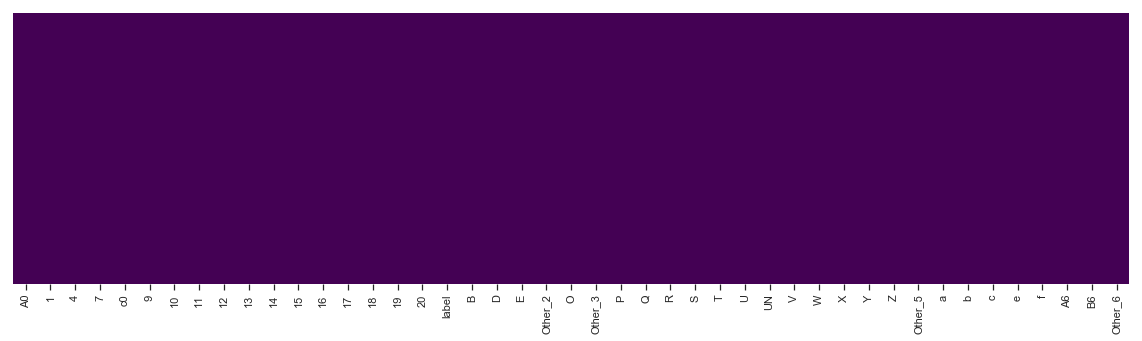

In [183]:
plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis');

In [184]:
df.shape

(24420, 45)

In [185]:
df_test.shape

(8141, 44)

# Outliers + Transformations + Clustering 

### Get Outliers Mask Function

**This function is calculating $Q1 - 1.5 * IQR$ and $Q3 + 1.5 * IQR$, finding the values that are out of this bounds and calculating number of this "outliers"**

In [186]:
def get_outliers_mask_fun(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    mask = (df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))
    print("Number of outliers for feature "+ column + " is: " + str(mask.sum()))
    print("-----------------------------------------")
    return mask

## Numeric features

**<font color='green'>Feature - 1</font>
<br><br>
As we could see on the graph and from values of "outliers" below, that they look not like outliers, they are grouped and on the same distance one from another, so we will not remove them**

In [187]:
mask_1 = get_outliers_mask_fun('1')
print(df['1'][mask_1].value_counts())

Number of outliers for feature 1 is: 1298
-----------------------------------------
3.0    491
4.0    392
2.0    259
1.0    118
0.0     38
Name: 1, dtype: int64


___

**<font color='green'>Feature - 9</font>
<br><br>
Here we can see something similar. As we could see on the graph and from values of "outliers" below, it seems they are not outliers, they are "grouped" and looks like a tail of distribution, so we will not remove them**

In [188]:
mask_9 = get_outliers_mask_fun('9')
print(df['9'][mask_9].value_counts())

Number of outliers for feature 9 is: 108
-----------------------------------------
7.235182    31
6.577663    18
6.511440    17
6.643794    16
6.709835     9
6.841657     7
6.775789     5
6.907442     2
7.104316     1
7.038769     1
6.973145     1
Name: 9, dtype: int64


### Let's try log transform our '9' feature 

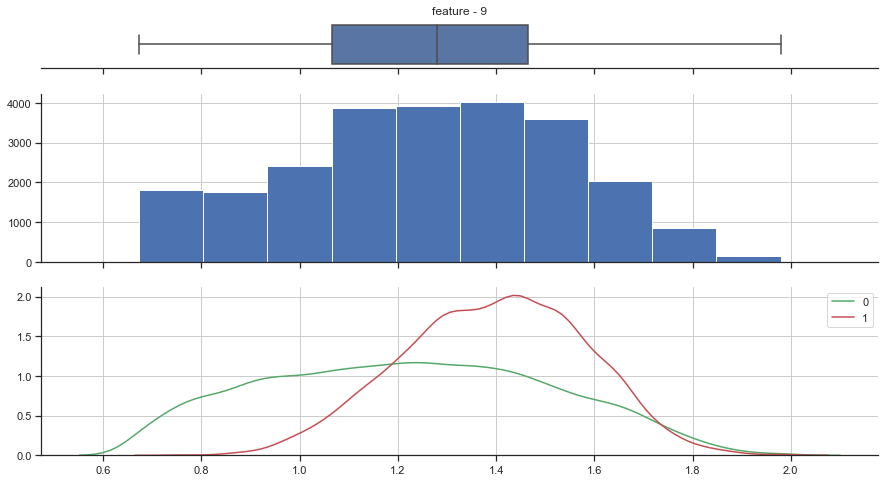

In [189]:
df['9'] = np.log(df['9'])
explor_func_graph('9')

### Test set

In [190]:
df_test['9'] = np.log(df_test['9'])

___

**<font color='green'>Feature - 10 ( Normal distributed )</font>
<br><br>
Let's remove outliers here and after we will use dropna to drop rows of outliers from table**

In [191]:
mask_10 = get_outliers_mask_fun('10')
print(df['10'][mask_10].value_counts())

Number of outliers for feature 10 is: 186
-----------------------------------------
-28.607406     1
-28.804258     1
-38.618214     1
-47.748933     1
 88.846799     1
-28.301803     1
 82.783581     1
 83.850323     1
-29.576568     1
-36.095417     1
 80.931911     1
 86.272816     1
 80.431455     1
-32.574329     1
-39.584225     1
 81.999699     1
 86.751563     1
 82.678494     1
-41.491091     1
 80.267956     1
 81.305220     1
 81.534878     1
-38.018339     1
-28.549475     1
-41.103160     1
 80.605194     1
-29.205434     1
-35.113694     1
 81.979310     1
-30.717808     1
              ..
-37.048792     1
-28.764495     1
-37.156248     1
-39.784801     1
-37.331161     1
-38.348484     1
 87.809317     1
 88.215710     1
 80.830051     1
 83.751345     1
-31.584764     1
-28.549162     1
 106.085572    1
-28.612803     1
 85.945851     1
-43.592052     1
-28.415366     1
-35.911780     1
 81.434958     1
 93.931928     1
 80.302497     1
-32.797062     1
 81.370522     

**Removing outliers**

In [192]:
df['10'] = df['10'][~mask_10]

___

**<font color='green'>Feature - 11</font>
<br><br>
Here we can see the strange 'outliers' also,values that mostly 9,10 and 16, let's not remove them for now**

In [193]:
mask_11 = get_outliers_mask_fun('11')
print(df['11'][mask_11].value_counts())

Number of outliers for feature 11 is: 54
-----------------------------------------
16.289653    23
10.304404     1
9.971537      1
10.089811     1
9.907546      1
10.047899     1
9.959325      1
10.119130     1
9.797230      1
9.903294      1
10.166093     1
9.936869      1
9.856936      1
9.829419      1
10.304304     1
9.842907      1
10.145599     1
9.974134      1
9.805505      1
10.198982     1
10.021138     1
10.038378     1
10.884087     1
10.634687     1
10.892054     1
9.997433      1
10.233047     1
9.831752      1
9.940896      1
9.805727      1
10.636705     1
10.418272     1
Name: 11, dtype: int64


___

**<font color='green'>Feature - 12</font>
<br><br>
As we saw on the graph, it's look like tail of distribution, so let's just try log transform our feature**

In [194]:
df['12'] = np.log(df['12']+100)

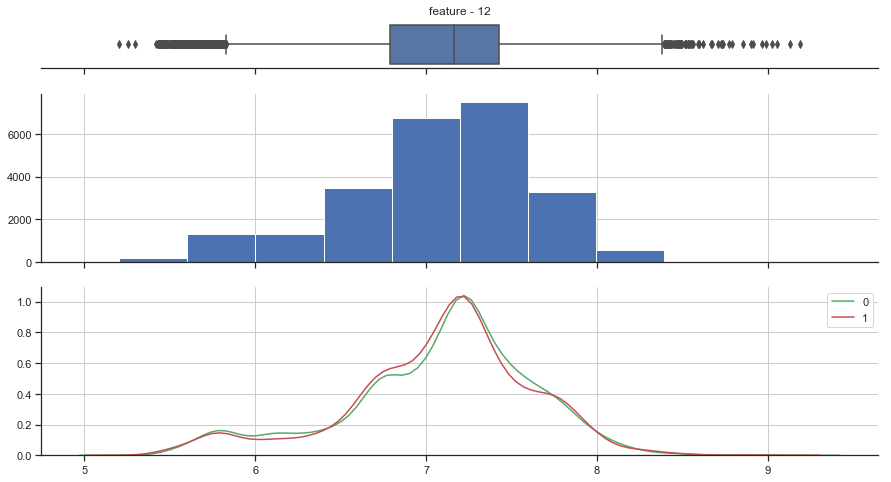

In [196]:
explor_func_graph('12')

### Test set

In [195]:
df_test['12'] = np.log(df_test['12']+100)

___

**<font color='green'>Feature - 13</font>
<br><br>
As we could see on the graph and from values of "outliers" below, that is not outliers, they are grouped and on the same distance one from another and we have 22 points of value 322.9, so we will not remove them**

In [197]:
mask_13 = get_outliers_mask_fun('13')
print(df['13'][mask_13].value_counts())

Number of outliers for feature 13 is: 933
-----------------------------------------
40.000000     491
30.000000     261
20.000000     119
10.000000      39
322.906667     23
Name: 13, dtype: int64


Here we checked perfomance of models without this "outliers"

In [198]:
#df['13'] = df['13'][df['13'] <300]

___

**<font color='green'>Feature - 14</font>
<br><br>
As we could see on the graph, that it is not outliers, they are grouped, so we will not remove them**

Number of outliers for feature 14 is: 1300
-----------------------------------------


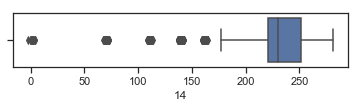

In [199]:
mask_14 = get_outliers_mask_fun('14')
plt.figure(figsize=(6,1))
sns.boxplot(df['14']);

___

**<font color='green'>Feature - 15</font>
<br><br>
As we could see on the graph,it's seems that value 12.999 not outliers, they are grouped, so we will not remove them**

Number of outliers for feature 15 is: 218
-----------------------------------------


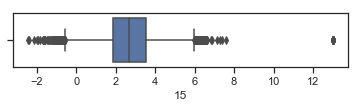

In [200]:
mask_15 = get_outliers_mask_fun('15')
plt.figure(figsize=(6,1))
sns.boxplot(df['15']);

In [201]:
mask_15_12= df['15'] > 8
df['15'][mask_15_12].value_counts()

12.999779    22
Name: 15, dtype: int64

In [202]:
#df['15'] = df['15'][df['15'] <12]

___

**<font color='green'>Feature - 16</font>
<br><br>
As we saw on the graph, it's look like tail of distribution, so let's just log transform our feature**

In [203]:
df['16'] = np.log(df['16']+100);

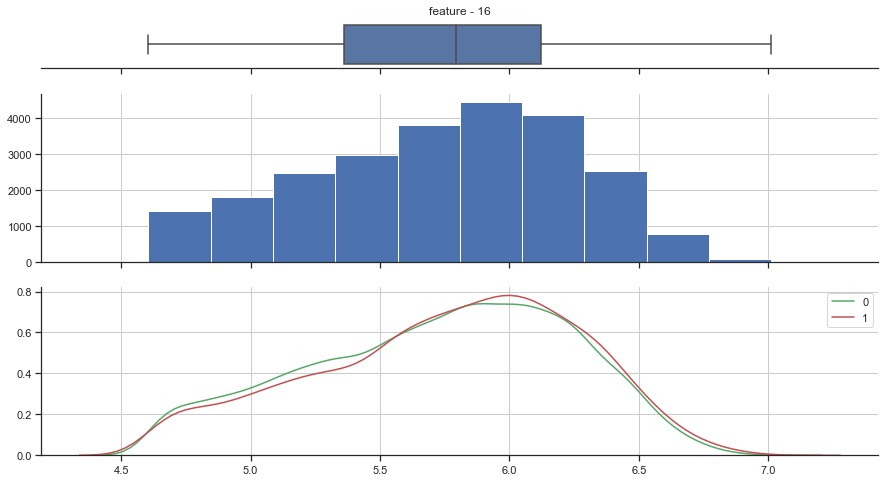

In [204]:
explor_func_graph('16')

### Test

In [205]:
df_test['16'] = np.log(df_test['16']+100);

___

**<font color='green'>Feature - 19</font>
<br><br>
We could see from the graph that it is too many "outliers" it seems that they are not and it is about 30% of rows and they look like tails of distribution, so let's leave it like it is**

In [206]:
mask_19 = get_outliers_mask_fun('19')

Number of outliers for feature 19 is: 6680
-----------------------------------------


___

**<font color='green'>Feature - 20</font>
<br><br>
As we could see on the graph and from values, that it is not outliers, they are grouped, so we will not remove them**

In [207]:
mask_20 = get_outliers_mask_fun('20')
print(df['20'][mask_20].value_counts())

Number of outliers for feature 20 is: 317
-----------------------------------------
 9.000000     124
-1.000000      70
 10.000000     59
 18.303329     28
 11.000000     20
-2.000000      12
 12.000000      3
-3.000000       1
Name: 20, dtype: int64


___

**<font color='green'>Rest of Features</font>
<br><br>
Rest of our features are binary so we do not need to check the outliers**

_____

In [208]:
df.isnull().sum()

A0           0
1            0
4            0
7            0
c0           0
9            0
10         186
11           0
12           0
13           0
14           0
15           0
16           0
17           0
18           0
19           0
20           0
label        0
B            0
D            0
E            0
Other_2      0
O            0
Other_3      0
P            0
Q            0
R            0
S            0
T            0
U            0
UN           0
V            0
W            0
X            0
Y            0
Z            0
Other_5      0
a            0
b            0
c            0
e            0
f            0
A6           0
B6           0
Other_6      0
dtype: int64

### Let's drop the rows with NaN values after we removed outliers

In [209]:
df.dropna(inplace = True)

dropping index to to get new consistent indexes ( because after we removed outliers, they are not )

In [210]:
df.reset_index(inplace = True)

In [211]:
df.drop('index', axis=1, inplace = True)

In [212]:
df.head(3)

A0     1    4    7  c0         9         10        11        12     13  \
0   1   5.0  0.0  1.0   1  1.299965   8.070319  6.834657  7.146037   60.0   
1   1  11.0  1.0  1.0   1  0.977635   4.058713  6.120013  6.883893  130.0   
2   0  10.0  0.0  1.0   1  1.693253  34.948770  9.145930  7.178093  100.0   

           14        15        16        17        18     19    20  label  B  \
0  181.278476  1.653801  6.234239  1.098612  3.135494  180.0  11.0      1  0   
1  256.966948  3.234822  5.885158  1.098612  1.609438   80.0   3.0      0  0   
2  231.301660  3.357442  6.603027  1.098612  1.609438  100.0   6.0      0  1   

   D  E  Other_2  O  Other_3  P  Q  R  S  T  U  UN  V  W  X  Y  Z  Other_5  a  \
0  1  0        0  0        0  0  0  0  0  1  0   0  0  0  0  0  0        0  1   
1  0  1        0  0        0  0  0  0  0  1  0   0  0  0  0  0  0        0  0   
2  0  0        0  0        0  0  0  1  0  0  0   0  0  0  0  0  0        0  1   

   b  c  e  f  A6  B6  Other_6  
0  0  0  0  0   1   0        0  
1  0  0  1  0   1   0        0  
2  0  0  0  0   1   0        0

**Checking if any nans in Test set**

In [213]:
df_test.isnull().any().sum()

0

____

# Clustering

**Let's add some new features using mathematical actions between columns**

**We will check AUC in some models with Clustering and without it. So let's creat copy of data to compare after**

In [214]:
df1 = df.copy()

In [215]:
df1['1*11'] = df['1']*df['11']
df1['10*11-12'] = (df['10']*df['11'])-df['12']
df1['19**2'] = (df['19']**2)
df1['16*20'] = df['16']*df['20']
df1['12*10-9'] = (df['12']*df['10'])-df['9']

### Test test

In [216]:
df_test['1*11'] = df_test['1']*df_test['11']
df_test['10*11-12'] = (df_test['10']*df_test['11'])-df_test['12']
df_test['19**2'] = (df_test['19']**2)
df_test['16*20'] = df_test['16']*df_test['20']
df_test['12*10-9'] = (df_test['12']*df_test['10'])-df_test['9']

In [217]:
df.shape,df1.shape,df_test.shape

((24234, 45), (24234, 50), (8141, 49))

In [218]:
df1.head(3)

A0     1    4    7  c0         9         10        11        12     13  \
0   1   5.0  0.0  1.0   1  1.299965   8.070319  6.834657  7.146037   60.0   
1   1  11.0  1.0  1.0   1  0.977635   4.058713  6.120013  6.883893  130.0   
2   0  10.0  0.0  1.0   1  1.693253  34.948770  9.145930  7.178093  100.0   

           14        15        16        17        18     19    20  label  B  \
0  181.278476  1.653801  6.234239  1.098612  3.135494  180.0  11.0      1  0   
1  256.966948  3.234822  5.885158  1.098612  1.609438   80.0   3.0      0  0   
2  231.301660  3.357442  6.603027  1.098612  1.609438  100.0   6.0      0  1   

   D  E  Other_2  O  Other_3  P  Q  R  S  T  U  UN  V  W  X  Y  Z  Other_5  a  \
0  1  0        0  0        0  0  0  0  0  1  0   0  0  0  0  0  0        0  1   
1  0  1        0  0        0  0  0  0  0  1  0   0  0  0  0  0  0        0  0   
2  0  0        0  0        0  0  0  1  0  0  0   0  0  0  0  0  0        0  1   

   b  c  e  f  A6  B6  Other_6       1*11    10*11-12    19**2      16*20  \
0  0  0  0  0   1   0        0  34.173284   48.011825  32400.0  68.576625   
1  0  0  1  0   1   0        0  67.320144   17.955482   6400.0  17.655474   
2  0  0  0  0   1   0        0  91.459296  312.460894  10000.0  39.618163   

      12*10-9  
0   56.370835  
1   26.962108  
2  249.172260

In [219]:
df_test.head(3)

A0     1    4    7  c0         9         10        11        12     13  \
0   1  10.0  1.0  1.0   1  1.092179  26.016737  5.894672  7.586188  100.0   
1   1  10.0  0.0  1.0   1  0.762574   2.125067  4.609658  8.016932  100.0   
2   1  10.0  1.0  0.0   1  1.065158 -26.346464  5.251290  7.289538  100.0   

           14        15        16        17        18    19   20  B  D  E  \
0  235.202236  2.141704  6.467365  1.098612  1.609438  80.0  4.0  0  0  1   
1  232.877280  0.870279  5.625044  1.098612  1.609438  30.0  2.0  0  1  0   
2  232.246162  1.768367  5.308452  1.098612  1.609438  80.0  5.0  0  0  1   

   Other_2  O  Other_3  P  Q  R  S  T  U  UN  V  W  X  Y  Z  Other_5  a  b  c  \
0        0  0        0  0  0  0  0  0  0   0  0  0  1  0  0        0  0  0  0   
1        0  0        0  0  0  0  0  0  0   0  0  0  0  1  0        0  0  0  1   
2        0  0        0  0  1  0  0  0  0   0  0  0  0  0  0        0  0  0  0   

   e  f  A6  B6  Other_6       1*11    10*11-12   19**2      16*20     12*10-9  
0  1  0   1   0        0  58.946717  145.773933  6400.0  25.869461  196.275677  
1  0  0   1   0        0  46.096581    1.778902   900.0  11.250088   16.273946  
2  0  1   1   0        0  52.512896 -145.642448  6400.0  26.542259 -193.118698

### Let's create copy of data to check other ways of normalization of our data and compare perfomance of models

In [220]:
df2 = df1.copy()

In [221]:
df2.head(2)

A0     1    4    7  c0         9        10        11        12     13  \
0   1   5.0  0.0  1.0   1  1.299965  8.070319  6.834657  7.146037   60.0   
1   1  11.0  1.0  1.0   1  0.977635  4.058713  6.120013  6.883893  130.0   

           14        15        16        17        18     19    20  label  B  \
0  181.278476  1.653801  6.234239  1.098612  3.135494  180.0  11.0      1  0   
1  256.966948  3.234822  5.885158  1.098612  1.609438   80.0   3.0      0  0   

   D  E  Other_2  O  Other_3  P  Q  R  S  T  U  UN  V  W  X  Y  Z  Other_5  a  \
0  1  0        0  0        0  0  0  0  0  1  0   0  0  0  0  0  0        0  1   
1  0  1        0  0        0  0  0  0  0  1  0   0  0  0  0  0  0        0  0   

   b  c  e  f  A6  B6  Other_6       1*11   10*11-12    19**2      16*20  \
0  0  0  0  0   1   0        0  34.173284  48.011825  32400.0  68.576625   
1  0  0  1  0   1   0        0  67.320144  17.955482   6400.0  17.655474   

     12*10-9  
0  56.370835  
1  26.962108

In [222]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24234 entries, 0 to 24233
Data columns (total 50 columns):
A0          24234 non-null int64
1           24234 non-null float64
4           24234 non-null float64
7           24234 non-null float64
c0          24234 non-null int64
9           24234 non-null float64
10          24234 non-null float64
11          24234 non-null float64
12          24234 non-null float64
13          24234 non-null float64
14          24234 non-null float64
15          24234 non-null float64
16          24234 non-null float64
17          24234 non-null float64
18          24234 non-null float64
19          24234 non-null float64
20          24234 non-null float64
label       24234 non-null int64
B           24234 non-null uint8
D           24234 non-null uint8
E           24234 non-null uint8
Other_2     24234 non-null uint8
O           24234 non-null uint8
Other_3     24234 non-null uint8
P           24234 non-null uint8
Q           24234 non-null uint8
R  

**Converting all binary to type uint8**

In [223]:
df2[['A0','4','7','c0']] = df2[['A0','4','7','c0']].astype(np.uint8, copy = False)

In [224]:
#df2[['A0','4','7','c0','17','18']] = df2[['A0','4','7','c0','17','18']].astype(np.uint8, copy = False)

**Let's split data to binary and numeric, so we could apply Standartization and PCA on numeric data and after concatinate them back together**

In [225]:
data_binary = df2.select_dtypes(exclude=['float64'])
data_binary.head(3)

A0  4  7  c0  label  B  D  E  Other_2  O  Other_3  P  Q  R  S  T  U  UN  V  \
0   1  0  1   1      1  0  1  0        0  0        0  0  0  0  0  1  0   0  0   
1   1  1  1   1      0  0  0  1        0  0        0  0  0  0  0  1  0   0  0   
2   0  0  1   1      0  1  0  0        0  0        0  0  0  1  0  0  0   0  0   

   W  X  Y  Z  Other_5  a  b  c  e  f  A6  B6  Other_6  
0  0  0  0  0        0  1  0  0  0  0   1   0        0  
1  0  0  0  0        0  0  0  0  1  0   1   0        0  
2  0  0  0  0        0  1  0  0  0  0   1   0        0

In [226]:
data_binary.shape

(24234, 32)

In [227]:
data_numeric = df2.select_dtypes(include=['float64'])
data_numeric.head(3)

1         9         10        11        12     13          14        15  \
0   5.0  1.299965   8.070319  6.834657  7.146037   60.0  181.278476  1.653801   
1  11.0  0.977635   4.058713  6.120013  6.883893  130.0  256.966948  3.234822   
2  10.0  1.693253  34.948770  9.145930  7.178093  100.0  231.301660  3.357442   

         16        17        18     19    20       1*11    10*11-12    19**2  \
0  6.234239  1.098612  3.135494  180.0  11.0  34.173284   48.011825  32400.0   
1  5.885158  1.098612  1.609438   80.0   3.0  67.320144   17.955482   6400.0   
2  6.603027  1.098612  1.609438  100.0   6.0  91.459296  312.460894  10000.0   

       16*20     12*10-9  
0  68.576625   56.370835  
1  17.655474   26.962108  
2  39.618163  249.172260

In [228]:
data_numeric.shape

(24234, 18)

### Spliting Test Set

In [229]:
df_test.head(3)

A0     1    4    7  c0         9         10        11        12     13  \
0   1  10.0  1.0  1.0   1  1.092179  26.016737  5.894672  7.586188  100.0   
1   1  10.0  0.0  1.0   1  0.762574   2.125067  4.609658  8.016932  100.0   
2   1  10.0  1.0  0.0   1  1.065158 -26.346464  5.251290  7.289538  100.0   

           14        15        16        17        18    19   20  B  D  E  \
0  235.202236  2.141704  6.467365  1.098612  1.609438  80.0  4.0  0  0  1   
1  232.877280  0.870279  5.625044  1.098612  1.609438  30.0  2.0  0  1  0   
2  232.246162  1.768367  5.308452  1.098612  1.609438  80.0  5.0  0  0  1   

   Other_2  O  Other_3  P  Q  R  S  T  U  UN  V  W  X  Y  Z  Other_5  a  b  c  \
0        0  0        0  0  0  0  0  0  0   0  0  0  1  0  0        0  0  0  0   
1        0  0        0  0  0  0  0  0  0   0  0  0  0  1  0        0  0  0  1   
2        0  0        0  0  1  0  0  0  0   0  0  0  0  0  0        0  0  0  0   

   e  f  A6  B6  Other_6       1*11    10*11-12   19**2      16*20     12*10-9  
0  1  0   1   0        0  58.946717  145.773933  6400.0  25.869461  196.275677  
1  0  0   1   0        0  46.096581    1.778902   900.0  11.250088   16.273946  
2  0  1   1   0        0  52.512896 -145.642448  6400.0  26.542259 -193.118698

In [230]:
df_test[['A0','4','7','c0']] = df_test[['A0','4','7','c0']].astype(np.uint8, copy = False)

In [231]:
#df_test[['A0','4','7','c0','17','18']] = df_test[['A0','4','7','c0','17','18']].astype(np.uint8, copy = False)

In [232]:
test_binary = df_test.select_dtypes(exclude=['float64'])
test_binary.head(3)

A0  4  7  c0  B  D  E  Other_2  O  Other_3  P  Q  R  S  T  U  UN  V  W  X  \
0   1  1  1   1  0  0  1        0  0        0  0  0  0  0  0  0   0  0  0  1   
1   1  0  1   1  0  1  0        0  0        0  0  0  0  0  0  0   0  0  0  0   
2   1  1  0   1  0  0  1        0  0        0  0  1  0  0  0  0   0  0  0  0   

   Y  Z  Other_5  a  b  c  e  f  A6  B6  Other_6  
0  0  0        0  0  0  0  1  0   1   0        0  
1  1  0        0  0  0  1  0  0   1   0        0  
2  0  0        0  0  0  0  0  1   1   0        0

In [233]:
test_binary.shape

(8141, 31)

In [234]:
test_numeric = df_test.select_dtypes(include=['float64'])
test_numeric.head(3)

1         9         10        11        12     13          14        15  \
0  10.0  1.092179  26.016737  5.894672  7.586188  100.0  235.202236  2.141704   
1  10.0  0.762574   2.125067  4.609658  8.016932  100.0  232.877280  0.870279   
2  10.0  1.065158 -26.346464  5.251290  7.289538  100.0  232.246162  1.768367   

         16        17        18    19   20       1*11    10*11-12   19**2  \
0  6.467365  1.098612  1.609438  80.0  4.0  58.946717  145.773933  6400.0   
1  5.625044  1.098612  1.609438  30.0  2.0  46.096581    1.778902   900.0   
2  5.308452  1.098612  1.609438  80.0  5.0  52.512896 -145.642448  6400.0   

       16*20     12*10-9  
0  25.869461  196.275677  
1  11.250088   16.273946  
2  26.542259 -193.118698

In [235]:
test_numeric.shape

(8141, 18)

___

# Normalization <br>
### *<font color='red'>Please pay attention that we are tried 2 way of normalization in parallel and after we compared them on our models results we choose Standartization ( Z-Score ) and we commented out other way further</font>*


**Let's try Standartization ( Z-score )**

In [236]:
standard_scaler = StandardScaler()
sclr = standard_scaler.fit(data_numeric);

In [237]:
z_scaled = pd.DataFrame(sclr.transform(data_numeric))

In [238]:
z_scaled.head(3)

0         1         2         3         4         5         6   \
0 -1.756266  0.135229 -0.933906  0.378171  0.115357 -1.536028 -1.465367   
1  0.984547 -1.023069 -1.140760 -0.202304 -0.360275  1.088823  0.918872   
2  0.527745  1.548515  0.452054  2.255519  0.173519 -0.036113  0.110398   

         7         8         9         10        11        12        13  \
0 -0.831950  0.989683 -0.285594  5.336209  4.006166  4.113748 -1.229728   
1  0.424048  0.300454 -0.285594 -0.222908 -0.043186 -0.635193  0.609995   
2  0.521461  1.717824 -0.285594 -0.222908  0.766685  1.145660  1.949772   

         14        15        16        17  
0 -0.856378  5.779839  4.564258 -0.922919  
1 -1.084658 -0.179144 -0.573712 -1.135267  
2  1.152135  0.645946  1.642334  0.469219

**Scaling Test set numeric values as we saw at the end that this way of standartization gives us better perfomance**

In [239]:
test_z_scaled = pd.DataFrame(sclr.transform(test_numeric))

In [240]:
test_z_scaled.head(3)

0         1         2         3         4         5         6   \
0  0.527745 -0.611453 -0.008517 -0.385339  0.913963 -0.036113  0.233268   
1  0.527745 -1.795893 -1.240467 -1.429101  1.695500 -0.036113  0.160031   
2  0.527745 -0.708554 -2.708573 -0.907931  0.375723 -0.036113  0.140150   

         7         8         9         10        11        12        13  \
0 -0.444349  1.449972 -0.285594 -0.222908 -0.043186 -0.041575  0.145252   
1 -1.454398 -0.213118 -0.285594 -0.222908 -2.067861 -1.228811 -0.567959   
2 -0.740936 -0.838202 -0.285594 -0.222908 -0.043186  0.552042 -0.211840   

         14        15        16        17  
0 -0.113867 -0.179144  0.255083  0.087275  
1 -1.207521 -1.439698 -1.220019 -1.212442  
2 -2.327198 -0.179144  0.322969 -2.724379

____

### **Using MinMaxScaller with and without new columns ( clustering )**

**Without new columns**

In [241]:
# scaler = MinMaxScaler()
# data_rescaled = pd.DataFrame(scaler.fit_transform(df.drop('label', axis=1).astype(float)))

In [242]:
# data_rescaled.head(3)

**Scaling data with new columns**

In [243]:
# scaler_c = MinMaxScaler()
# data_rescaled_c = pd.DataFrame(scaler.fit_transform(df1.drop('label', axis=1).astype(float)))

In [244]:
# data_rescaled_c.head(3)

______

## Feature selection and PCA

## PCA

### Checking for z-score normalized data

**Checking number of component's that explain 95% of variance**

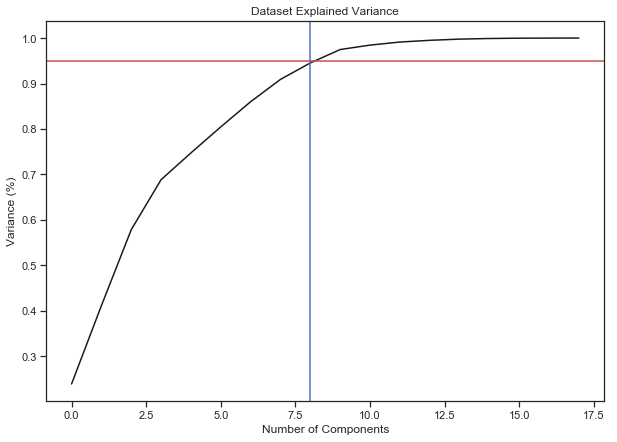

In [245]:
pca = PCA().fit(z_scaled)
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_),color='k')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Dataset Explained Variance')
plt.axvline(8, c='b')
plt.axhline(0.95, c='r')
plt.show();

**We can see above that the number of components is 8. Let's transform our numeric data to 8 features using PCA**

In [246]:
pca = PCA(n_components = 8)
z_pca = pca.fit(z_scaled)
z_num_dataset = pd.DataFrame(z_pca.transform(z_scaled))

In [247]:
z_num_dataset.head(3)

0         1         2         3         4         5         6  \
0  2.400777  8.688940 -4.214917  0.371665  4.275621 -0.075242  0.901768   
1  0.802464 -2.150030 -1.742905 -0.452621  0.034394 -0.102964 -0.394104   
2  2.973190  1.541715  1.294764  1.880456  0.312634 -1.851710  0.122739   

          7  
0  2.913327  
1 -0.309515  
2 -0.837565

In [248]:
z_num_dataset.shape

(24234, 8)

**Test set**

In [249]:
z_num_test = pd.DataFrame(z_pca.transform(test_z_scaled))

In [250]:
z_num_test.head(3)

0         1         2         3         4         5         6  \
0  0.064182 -0.195777 -0.186654 -0.812857  0.058826 -1.550244  0.630955   
1 -2.656984 -2.863203 -1.629944 -1.174992 -0.240090 -0.204389  1.465072   
2 -0.549590 -0.944904 -4.491675  0.251909 -0.171501  0.639085  0.446495   

          7  
0 -0.297771  
1 -0.207583  
2 -0.457520

In [251]:
z_num_test.shape

(8141, 8)

____

**Now let's concatinate this features with our binary features**

In [252]:
z_finalDf = pd.concat([z_num_dataset, data_binary], axis = 1)

In [253]:
z_finalDf.head(3)

0         1         2         3         4         5         6  \
0  2.400777  8.688940 -4.214917  0.371665  4.275621 -0.075242  0.901768   
1  0.802464 -2.150030 -1.742905 -0.452621  0.034394 -0.102964 -0.394104   
2  2.973190  1.541715  1.294764  1.880456  0.312634 -1.851710  0.122739   

          7  A0  4  7  c0  label  B  D  E  Other_2  O  Other_3  P  Q  R  S  T  \
0  2.913327   1  0  1   1      1  0  1  0        0  0        0  0  0  0  0  1   
1 -0.309515   1  1  1   1      0  0  0  1        0  0        0  0  0  0  0  1   
2 -0.837565   0  0  1   1      0  1  0  0        0  0        0  0  0  1  0  0   

   U  UN  V  W  X  Y  Z  Other_5  a  b  c  e  f  A6  B6  Other_6  
0  0   0  0  0  0  0  0        0  1  0  0  0  0   1   0        0  
1  0   0  0  0  0  0  0        0  0  0  0  1  0   1   0        0  
2  0   0  0  0  0  0  0        0  1  0  0  0  0   1   0        0

In [254]:
z_finalDf.shape

(24234, 40)

**Same for Test set**

In [255]:
z_final_test = pd.concat([z_num_test, test_binary], axis = 1)

In [256]:
z_final_test.head(3)

0         1         2         3         4         5         6  \
0  0.064182 -0.195777 -0.186654 -0.812857  0.058826 -1.550244  0.630955   
1 -2.656984 -2.863203 -1.629944 -1.174992 -0.240090 -0.204389  1.465072   
2 -0.549590 -0.944904 -4.491675  0.251909 -0.171501  0.639085  0.446495   

          7  A0  4  7  c0  B  D  E  Other_2  O  Other_3  P  Q  R  S  T  U  UN  \
0 -0.297771   1  1  1   1  0  0  1        0  0        0  0  0  0  0  0  0   0   
1 -0.207583   1  0  1   1  0  1  0        0  0        0  0  0  0  0  0  0   0   
2 -0.457520   1  1  0   1  0  0  1        0  0        0  0  1  0  0  0  0   0   

   V  W  X  Y  Z  Other_5  a  b  c  e  f  A6  B6  Other_6  
0  0  0  1  0  0        0  0  0  0  1  0   1   0        0  
1  0  0  0  1  0        0  0  0  1  0  0   1   0        0  
2  0  0  0  0  0        0  0  0  0  0  1   1   0        0

_____

**Let's split the data for train and target**

In [257]:
z_data_X = z_finalDf.drop('label', axis=1)
z_data_y = z_finalDf['label']

In [258]:
z_data_X.head(3)

0         1         2         3         4         5         6  \
0  2.400777  8.688940 -4.214917  0.371665  4.275621 -0.075242  0.901768   
1  0.802464 -2.150030 -1.742905 -0.452621  0.034394 -0.102964 -0.394104   
2  2.973190  1.541715  1.294764  1.880456  0.312634 -1.851710  0.122739   

          7  A0  4  7  c0  B  D  E  Other_2  O  Other_3  P  Q  R  S  T  U  UN  \
0  2.913327   1  0  1   1  0  1  0        0  0        0  0  0  0  0  1  0   0   
1 -0.309515   1  1  1   1  0  0  1        0  0        0  0  0  0  0  1  0   0   
2 -0.837565   0  0  1   1  1  0  0        0  0        0  0  0  1  0  0  0   0   

   V  W  X  Y  Z  Other_5  a  b  c  e  f  A6  B6  Other_6  
0  0  0  0  0  0        0  1  0  0  0  0   1   0        0  
1  0  0  0  0  0        0  0  0  0  1  0   1   0        0  
2  0  0  0  0  0        0  1  0  0  0  0   1   0        0

### Let's check the correlation heatmap ( we added back binary features, so lets check if there any correlations )

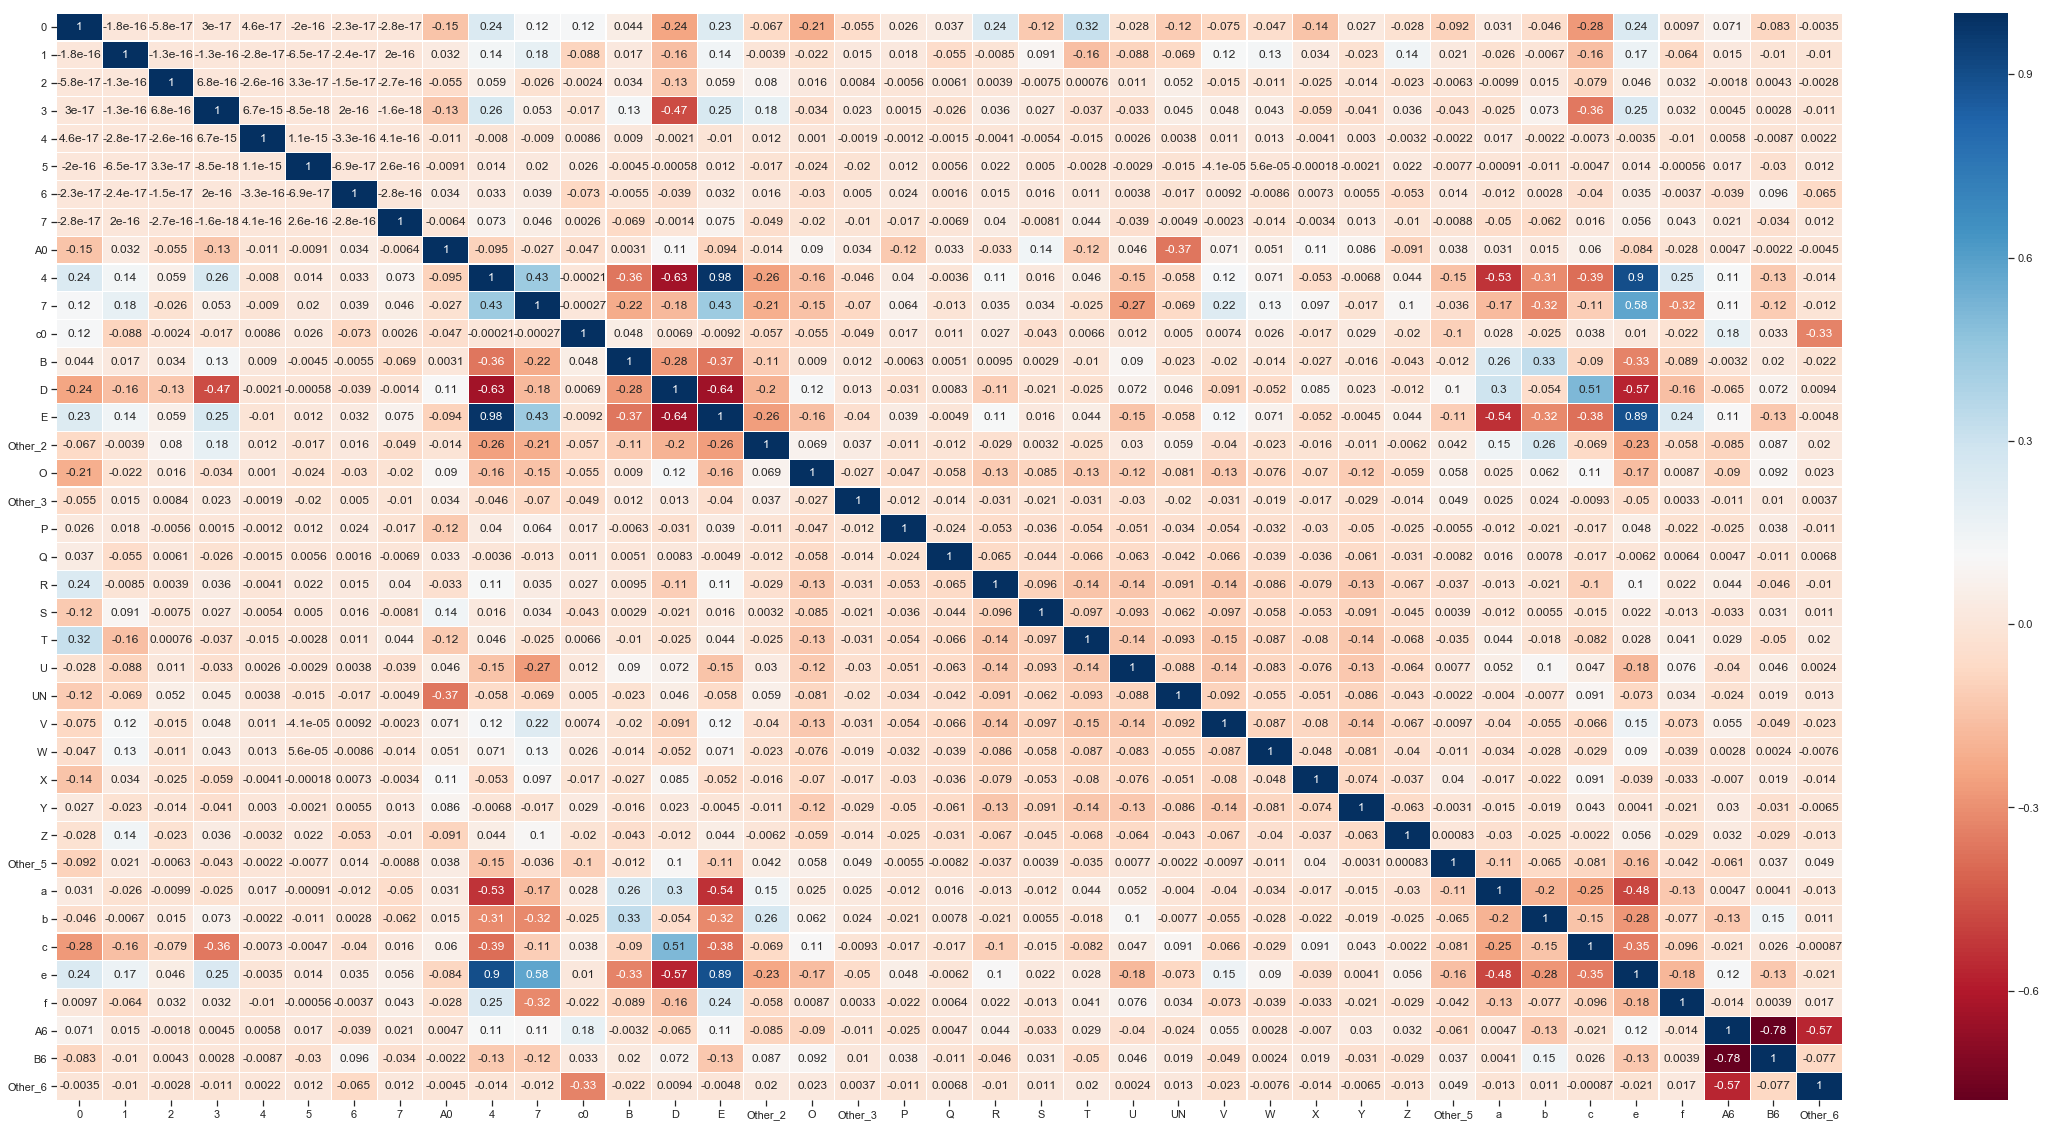

In [259]:
plt.figure(figsize=(40,20))
sns.heatmap(
    z_data_X.corr(),
    xticklabels=z_data_X.corr().columns.values,
    yticklabels=z_data_X.corr().columns.values,
    annot=True,
    linecolor='white',
    linewidths=0.1,
    cmap="RdBu"
)
plt.show()

**First let's drop features that correlates strongly ( > 0.85 )**

In [260]:
corr = z_data_X.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.85:
            if columns[j]:
                columns[j] = False
selected_columns = z_data_X.columns[columns]
z_data_X = z_data_X[selected_columns]

**The data is ready, we will check if it gives are better perfomance later in building models part**

In [261]:
z_data_X.head(3)

0         1         2         3         4         5         6  \
0  2.400777  8.688940 -4.214917  0.371665  4.275621 -0.075242  0.901768   
1  0.802464 -2.150030 -1.742905 -0.452621  0.034394 -0.102964 -0.394104   
2  2.973190  1.541715  1.294764  1.880456  0.312634 -1.851710  0.122739   

          7  A0  4  7  c0  B  D  Other_2  O  Other_3  P  Q  R  S  T  U  UN  V  \
0  2.913327   1  0  1   1  0  1        0  0        0  0  0  0  0  1  0   0  0   
1 -0.309515   1  1  1   1  0  0        0  0        0  0  0  0  0  1  0   0  0   
2 -0.837565   0  0  1   1  1  0        0  0        0  0  0  1  0  0  0   0  0   

   W  X  Y  Z  Other_5  a  b  c  f  A6  B6  Other_6  
0  0  0  0  0        0  1  0  0  0   1   0        0  
1  0  0  0  0        0  0  0  0  0   1   0        0  
2  0  0  0  0        0  1  0  0  0   1   0        0

## Final Training set

In [262]:
z_data_X.shape

(24234, 37)

In [263]:
z_data_y.shape

(24234,)

In [271]:
z_final_df = pd.concat([z_data_X,z_data_y],axis=1)

In [272]:
z_final_df.head(2)

0        1         2         3         4         5         6  \
0  2.400777  8.68894 -4.214917  0.371665  4.275621 -0.075242  0.901768   
1  0.802464 -2.15003 -1.742905 -0.452621  0.034394 -0.102964 -0.394104   

          7  A0  4  7  c0  B  D  Other_2  O  Other_3  P  Q  R  S  T  U  UN  V  \
0  2.913327   1  0  1   1  0  1        0  0        0  0  0  0  0  1  0   0  0   
1 -0.309515   1  1  1   1  0  0        0  0        0  0  0  0  0  1  0   0  0   

   W  X  Y  Z  Other_5  a  b  c  f  A6  B6  Other_6  label  
0  0  0  0  0        0  1  0  0  0   1   0        0      1  
1  0  0  0  0        0  0  0  0  0   1   0        0      0

In [273]:
z_final_df.shape

(24234, 38)

## Final Test set

**Droping same columns in test set and getting final Test set ready for prediction**

In [444]:
z_final_test = z_final_test[list(z_data_X.columns)]

In [445]:
z_final_test.head(3)

0         1         2         3         4         5         6  \
0  0.064182 -0.195777 -0.186654 -0.812857  0.058826 -1.550244  0.630955   
1 -2.656984 -2.863203 -1.629944 -1.174992 -0.240090 -0.204389  1.465072   
2 -0.549590 -0.944904 -4.491675  0.251909 -0.171501  0.639085  0.446495   

          7  A0  4  7  c0  B  D  Other_2  O  Other_3  P  Q  R  S  T  U  UN  V  \
0 -0.297771   1  1  1   1  0  0        0  0        0  0  0  0  0  0  0   0  0   
1 -0.207583   1  0  1   1  0  1        0  0        0  0  0  0  0  0  0   0  0   
2 -0.457520   1  1  0   1  0  0        0  0        0  0  1  0  0  0  0   0  0   

   W  X  Y  Z  Other_5  a  b  c  f  A6  B6  Other_6  
0  0  1  0  0        0  0  0  0  0   1   0        0  
1  0  0  1  0        0  0  0  1  0   1   0        0  
2  0  0  0  0        0  0  0  0  1   1   0        0

In [446]:
z_final_test.shape

(8141, 37)

_____

### *<font color='red'>Please pay attention that we are tried runnig our models with and without new features ( clustering ) and after we compared the results we choose to leave new columns in our data as we got higher perfomances and we commented out the way without new columns because of running time constraints</font>*



### PCA with MinMax Scaled data

### PCA ( Data without clustering )

**Checking number of component's that explain 95% of variance**

In [264]:
# pca = PCA().fit(data_rescaled)
# plt.figure(figsize=(10,7))
# plt.plot(np.cumsum(pca.explained_variance_ratio_),color='k')
# plt.xlabel('Number of Components')
# plt.ylabel('Variance (%)')
# plt.title('Dataset Explained Variance')
# plt.axvline(24, c='b')
# plt.axhline(0.95, c='r')
# plt.show();

### PCA ( columns with clustering )

**We can see that the number of components is 24 for data without new columns**

In [265]:
# pca = PCA().fit(data_rescaled_c)
# plt.figure(figsize=(10,7))
# plt.plot(np.cumsum(pca.explained_variance_ratio_),color='k')
# plt.xlabel('Number of Components')
# plt.ylabel('Variance (%)')
# plt.title('Dataset Explained Variance')
# plt.axvline(24, c='b')
# plt.axhline(0.95, c='r')
# plt.show();

**We can see that the number of components is 24 for data with new columns ( clustering )**

In [266]:
# pca = PCA(n_components = 24)
# dataset_no_clustering = pd.DataFrame(pca.fit_transform(data_rescaled))
# labels_no_clustering = df['label']

In [257]:
# pca = PCA(n_components = 24)
# dataset = pd.DataFrame(pca.fit_transform(data_rescaled_c))
# labels = df1['label']

In [258]:
# finalDf_no_clustering = pd.concat([dataset_no_clustering, labels_no_clustering], axis = 1)

In [259]:
#finalDf = pd.concat([dataset, labels], axis = 1)

### We will compare the results of data with and without clustering on Logistic Regression and decide with wich of them to work

In [267]:
#finalDf.head()

In [269]:
#finalDf_no_clustering.head()

# Let's look at our features ones again

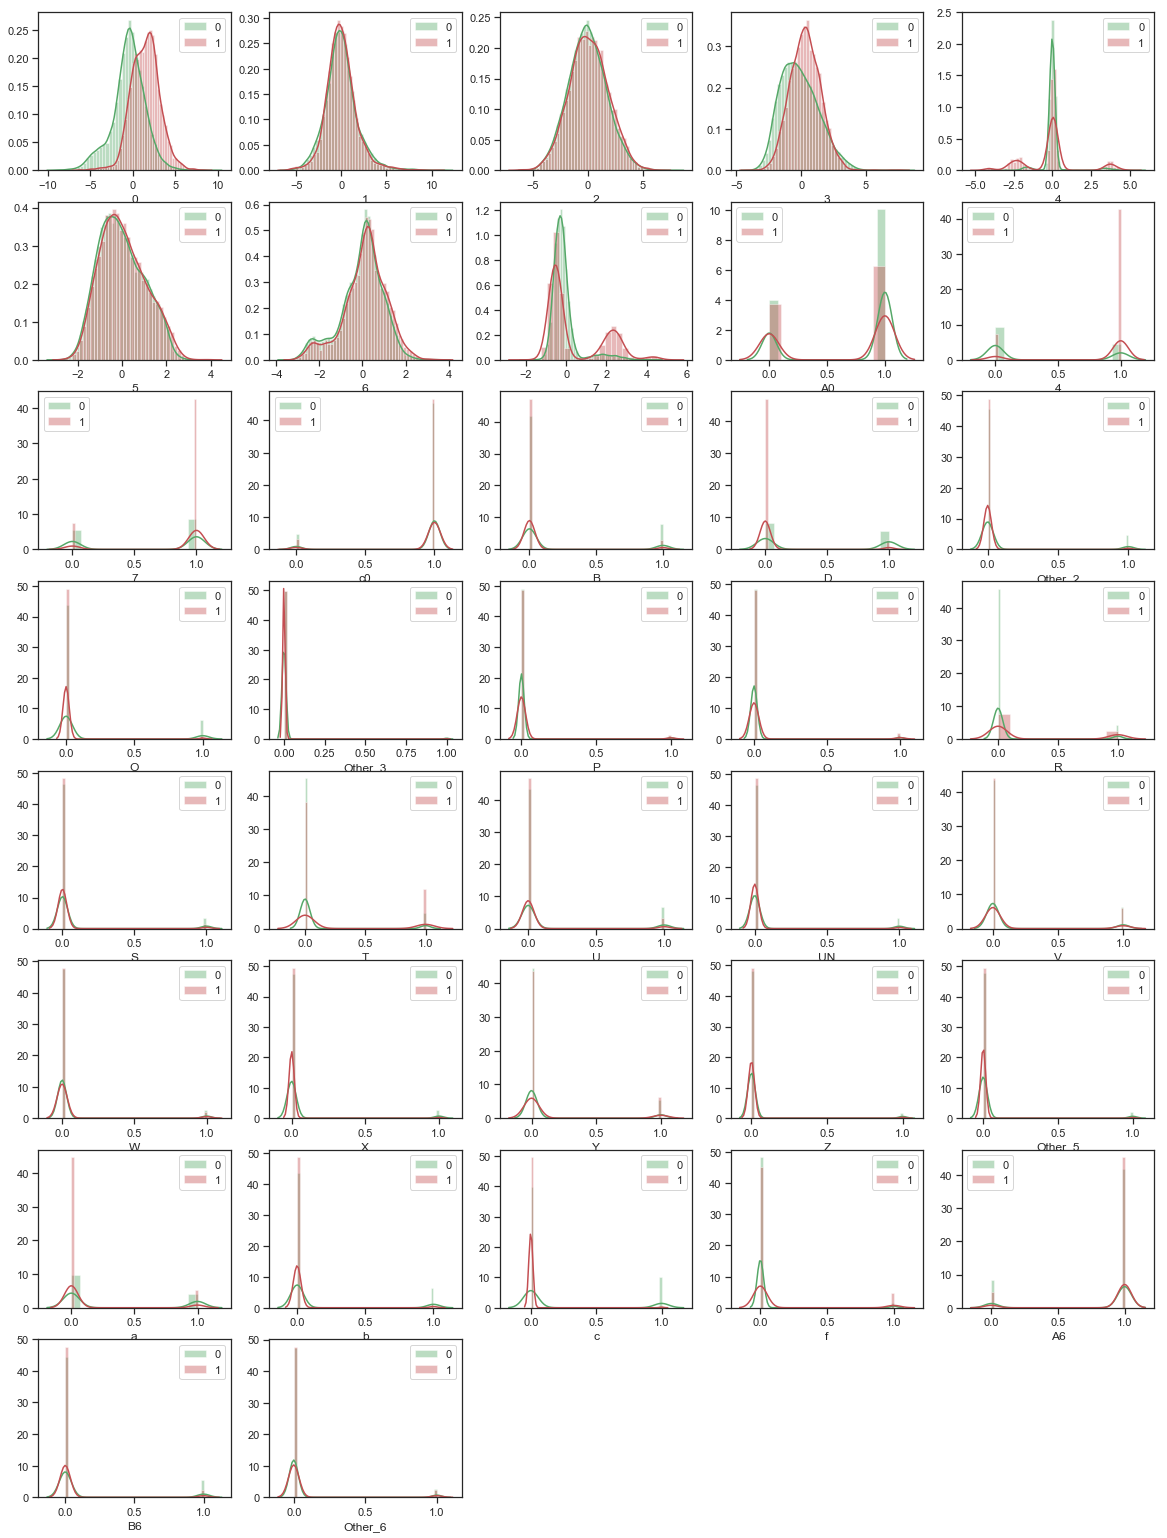

In [282]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in z_final_df.drop('label', axis=1).columns:
    plt.subplot(8, 5, j+1)
    j += 1
    sns.distplot(z_final_df[i][z_final_df['label']==0], color='g', label = '0')
    sns.distplot(z_final_df[i][z_final_df['label']==1], color='r', label = '1')
    plt.legend(loc='best')
fig.subplots_adjust(top=0.95)
plt.show();

**We can assume from the graphs already that Naive Baise will less effective for our data**

____________

# 3+4. Building models and Evaluations

## K-folds and ROC preparations ( + Confusion Matrix of every Fold  )

### Function for running K-Folds ( preparing and returning all data that we will need for ROC plots, Confusion Matrix and checking Overfitting )

In [382]:
def KfoldRoc(X, y, clf, k, model_name):
    
    all_tpr = [] #defining empty array to save every tpr of K
    
    tpr_test = []
    fpr_test = []
    test_auc_list = []
    
    tpr_train = []
    fpr_train = []
    train_auc_list = []
    
    accuracy_list = []
    
    #list of Confusion Matricies of every fold of Naive Bayes
    cml = []
        
    kf = KFold(n_splits = k, random_state = 23, shuffle = True) 
    
    #runing over every fold and training the model on data of fold
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        
        #testing model on validation set from fold and getting probabilities for label 1
        y_prob_1 = clf.predict_proba(X_test)[:,1]
        fpr, tpr, tresholds = roc_curve(y_test, y_prob_1) #getting fpr, tpr and threshold
        
        #Accuracy
        prediction = clf.predict(X_test)
        accuracy_list.append(metrics.accuracy_score(prediction,y_test))
        
        #building Confusion Matrix of every fold        
        cm = confusion_matrix(y_test,clf.predict(X_test))
        tn,fp,fn,tp = cm.ravel()
        c = np.array([[tp,fp],[fn,tn]])
        cml.append(c)
            
        
        
        #interpulation
        tpr_interp = np.interp(np.linspace(0,1,100), fpr, tpr)
        fpr_interp = np.linspace(0,1,100)
        
        tpr_test.append(tpr_interp)
        fpr_test.append(fpr_interp)
        
        test_auc_list.append(auc(fpr_interp,tpr_interp))

        all_tpr.append(tpr_interp)
        
        #check overfitting
        y_prob_1_train = clf.predict_proba(X_train)[:,1]
        fpr, tpr, tresholds = roc_curve(y_train, y_prob_1_train) #getting fpr, tpr and threshold
        train_auc = auc(fpr,tpr)
        
        train_auc_list.append(train_auc)
        tpr_train.append(tpr)
        fpr_train.append(fpr)
    
    tpr_mean = np.mean(all_tpr, axis=0)  #calculating mean of all tpr
    
    accuracy_mean = np.mean(accuracy_list, axis=0) #calculating mean accuracy
    
    auc_mean = auc(np.linspace(0,1,100), tpr_mean)#getting area under the curve
    
    
    return tpr_test, fpr_test, tpr_mean, auc_mean, tpr_train, fpr_train, train_auc_list, test_auc_list, cml, accuracy_mean
    

        

## Ploting ROC functions

### Function for plotting ROC and mean AUC of all folds

In [284]:
def PlotMeanRoc(tpr_test, fpr_test, tpr_mean, auc_mean):
    #building graph
    plt.figure(figsize=(10,7)) 
    plt.plot([0,1],[0,1], color = 'navy', linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('ROC for ')
    
    for i in range(len(tpr_test)):
        plt.plot(fpr_test[i], tpr_test[i], color = 'grey')   #adding lines to graph for every k
    plt.plot([],[],color = 'grey',label = 'K-folds')  #adding label for grey lines
    
    auc_mean_str = str(auc_mean)#getting area under the curve and convert it to string
    
    plt.plot(np.linspace(0,1,100), tpr_mean, color = 'red',label = 'Mean ROC ( area = ' + ('%.5s' %auc_mean_str) + ' )')
    plt.legend()
    plt.show()


### Function for plotting ROC for every fold

In [285]:
def PlotFoldRoc(tpr_test, fpr_test, tpr_mean, test_auc_list):
    #building graph
    plt.figure(figsize=(10,7)) 
    plt.plot([0,1],[0,1], color = 'navy', linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('ROC for ')
    colors = ['aqua', 'darkorange', 'grey', 'green', 'blue','cyan','magenta', 'cornflowerblue', 'yellow', 'black']
    
    for i in range(len(tpr_test)):
        plt.plot(fpr_test[i], tpr_test[i], color = colors[i], label = 'Fold ' + str(i+1)+ '( area = ' + ('%.5s' %str(test_auc_list[i])) + ' )')   
    plt.legend()
    plt.show()

### Function for plotting ROC for every fold that got from predictictons on TRAINING SET

In [286]:
def PlotOverfitRoc(tpr_train, fpr_train, train_auc):
    #building graph
    plt.figure(figsize=(10,7)) 
    plt.plot([0,1],[0,1], color = 'navy', linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('ROC for ')
    colors = ['aqua', 'darkorange', 'grey', 'green', 'blue','cyan','magenta', 'cornflowerblue', 'yellow', 'black']
    
    for i in range(len(tpr_train)):
        plt.plot(fpr_train[i], tpr_train[i], color = colors[i] ,label = 'Fold ' + str(i+1)+ '( area = ' + ('%.5s' %str(train_auc[i])) + ' )')
    plt.legend()
    plt.show()

___________

### Defining dictionaries to save mean AUC and TPR for final graph for all models comparison

In [288]:
AUC_mean = {}

In [289]:
TPR_mean = {}

In [380]:
Accuracy_mean = {}

____

# Building initial models and evaluation

### *<font color='red'>First we will evaluated perfomance of Logistic Regression on 3 sets of data: 1 - Z-score normalized data with clustering features, 2 - MinMax Normalized after clustering, 3 - MinMax normalized before clustering </font>*

### *<font color='red'> As mentioned before, we commented out MINMAX with and without clusterin, because we compared all the ways already and we know that Z-score with new columns gives us better perfomance</font>*

# Logistic Regression ( with Z-score normalized data )

**Using GridSearch to find best of our hyperparameters**

In [294]:
LRParametersOptions = {'penalty' : ['l1', 'l2'],
                      'C' : [ 0.01, 0.1, 0.5, 0.75, 1, 10, 100 ],
                      'tol' : [ 0.0001 ],
                      'max_iter' : [1000],
                      'random_state' :[23],
                      'solver' : ["liblinear"]}

kfold = KFold(n_splits = 5, random_state = 23, shuffle = True)
GS_LR = GridSearchCV(LogisticRegression(), LRParametersOptions, cv = kfold, scoring = 'roc_auc', n_jobs = -1 )

GS_LR.fit(z_data_X, z_data_y);

In [295]:
print ('LR chosen parameters (recieved best AUC): {}'.format(GS_LR.best_params_))
print ("LR AUC score with the chosen parameters: ", GS_LR.best_score_)

LR chosen parameters (recieved best AUC): {'C': 0.5, 'max_iter': 1000, 'penalty': 'l2', 'random_state': 23, 'solver': 'liblinear', 'tol': 0.0001}
LR AUC score with the chosen parameters:  0.8993415504251063


### Logistic Regression with best params

In [296]:
clf = LogisticRegression(**GS_LR.best_params_)
tpr_test_lr, fpr_test_lr, tpr_mean_lr, auc_mean_lr, tpr_train_lr, fpr_train_lr, train_auc_list_lr, test_auc_list_lr,cml_lr,accuracy_lr\
= KfoldRoc(z_data_X.values, z_data_y.values, clf, 5,'LR')

### Mean ROC ( Z-score normalized data )

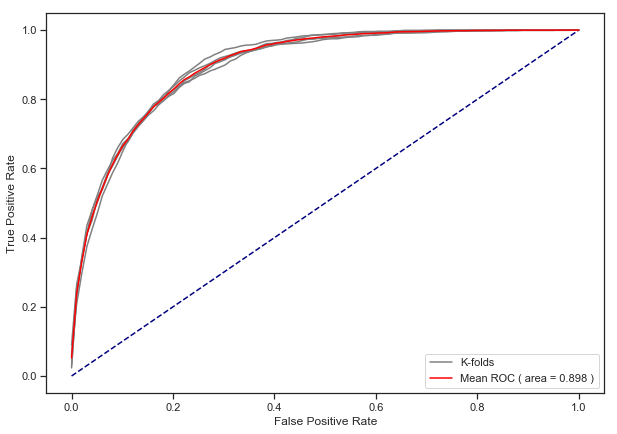

In [297]:
PlotMeanRoc(tpr_test_lr, fpr_test_lr, tpr_mean_lr, auc_mean_lr)

### Fold's ROC ( predictions on Validation set )

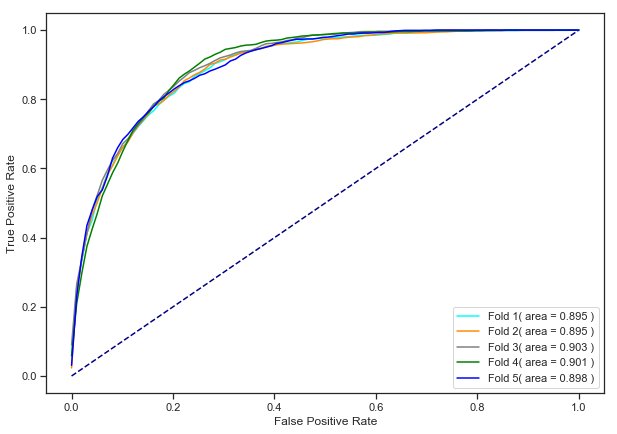

In [298]:
PlotFoldRoc(tpr_test_lr, fpr_test_lr, tpr_mean_lr, test_auc_list_lr)

### Overfitting check ( prediction on Training set )

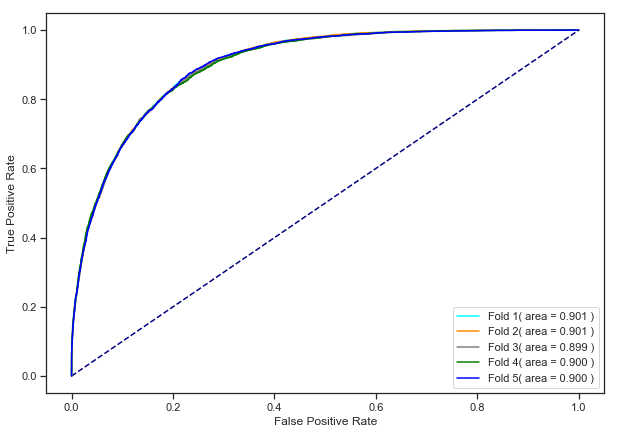

In [299]:
PlotOverfitRoc(tpr_train_lr, fpr_train_lr, train_auc_list_lr)

**We can see above that there is no overfitting, model have almost the same abilities when getting data never seen before**

In [300]:
AUC_mean["Logistic Regression"] = auc_mean_lr 

In [301]:
TPR_mean["Logistic Regression"] = tpr_mean_lr

In [ ]:
Accuracy_mean["Logistic Regression"] = accuracy_lr

_____

# Logistic Regression ( with MinMax Normalized data )

In [302]:
# LRParametersOptions = {'penalty' : ['l1', 'l2'],
#                       'C' : [ 0.01, 0.1, 0.5, 0.75, 1, 10, 100 ],
#                       'tol' : [ 0.0001 ],
#                       'max_iter' : [1000],
#                       'random_state' :[23],
#                       'solver' : ["liblinear"]}

# kfold = KFold(n_splits = 5, random_state = 23)
# GS_LR = GridSearchCV(LogisticRegression(), LRParametersOptions, cv = kfold, scoring = 'roc_auc', n_jobs = -1 )

# GS_LR.fit(dataset, labels);

In [303]:
# print ('LR chosen parameters (recieved best AUC): {}'.format(GS_LR.best_params_))
# print ("LR AUC score with the chosen parameters: ", GS_LR.best_score_)

### We could see that using data with new columns using clustering giving us higher AUC ( 0.88 > 0.87 )

***We will use data with new columns in our all models***

### Mean ROC after clustering

In [304]:
# clf = LogisticRegression(**GS_LR.best_params_)
# tpr_test_lr, fpr_test_lr, tpr_mean_lr, auc_mean_lr, tpr_train_lr, fpr_train_lr, train_auc_list_lr, test_auc_list_lr,cml_lr,accuracy_lr\
# = KfoldRoc(dataset.values, labels.values, clf, 5,'LR')

In [305]:
# PlotMeanRoc(tpr_test_lr, fpr_test_lr, tpr_mean_lr, auc_mean_lr)

### *<font color='red'> We saw from the code below, AUC ( before Clustering ) = 0.87 < AUC ( Clustering ) = 0.88, so we choosed to use our added columns<br><br> Remember, we already checked it and put it into comment </font>*

### Mean ROC before clustering

In [306]:
# clf = LogisticRegression(**GS_LR.best_params_)
# tpr_test_lr, fpr_test_lr, tpr_mean_lr, auc_mean_lr, tpr_train_lr, fpr_train_lr, train_auc_list_lr, test_auc_list_lr,cml_lr,accuracy_lr\
# = KfoldRoc(dataset_no_clustering.values, labels_no_clustering.values, clf, 5,'LR')

In [307]:
# PlotMeanRoc(tpr_test_lr, fpr_test_lr, tpr_mean_lr, auc_mean_lr)

### Fold ROC

In [308]:
# PlotFoldRoc(tpr_test_lr, fpr_test_lr, tpr_mean_lr, test_auc_list_lr)

### Overfitting Check

In [309]:
# PlotOverfitRoc(tpr_train_lr, fpr_train_lr, train_auc_list_lr)

### *<font color='red'>After this results with z-score normalization AUC = 0.89 > AUC = 0.88 that we got from data that was MinMax Normalized, was decided to use data that normalized with Z-score for all models</font>*

____

# KNN

### Searching best of given hyperparameters

In [316]:
KnnParametersOptions = {'n_neighbors' : [3,5,11,19], 
                       'weights' : [ 'uniform', 'distance'],
                       'metric' : ['euclidean', 'manhattan'],
                           'n_jobs':[-1]}

kfold = KFold(n_splits = 5, random_state = 23)
GS_KNN = GridSearchCV(neighbors.KNeighborsClassifier(), KnnParametersOptions, cv = kfold, scoring = 'roc_auc', n_jobs = -1 )

GS_KNN.fit(z_data_X, z_data_y);

In [317]:
print ('KNN chosen parameters (recieved best AUC): {}'.format(GS_KNN.best_params_))
print ("KNN AUC score with the chosen parameters: ", GS_KNN.best_score_)

KNN chosen parameters (recieved best AUC): {'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 19, 'weights': 'distance'}
KNN AUC score with the chosen parameters:  0.8939917831960986


### KNN with best params

In [319]:
clf = neighbors.KNeighborsClassifier(**GS_KNN.best_params_)
tpr_test_knn, fpr_test_knn, tpr_mean_knn, auc_mean_knn, tpr_train_knn, fpr_train_knn, train_auc_list_knn, test_auc_list_knn,cml_knn,accuracy_knn\
= KfoldRoc(z_data_X.values, z_data_y.values, clf, 5,'KNN')


### Mean ROC

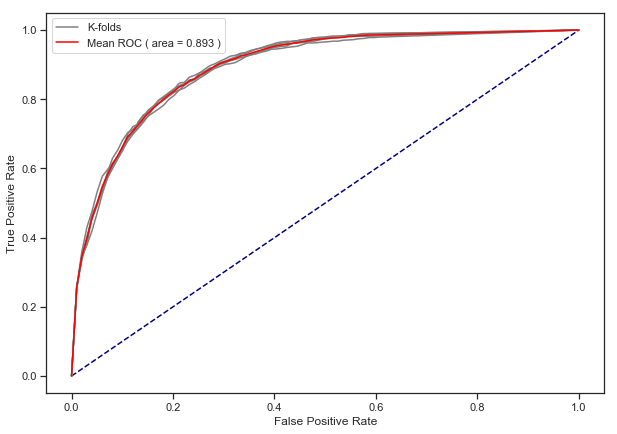

In [320]:
PlotMeanRoc(tpr_test_knn, fpr_test_knn, tpr_mean_knn, auc_mean_knn)

### Fold ROC

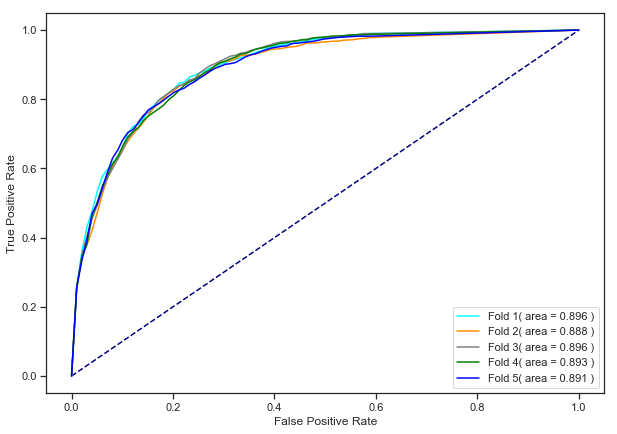

In [321]:
PlotFoldRoc(tpr_test_knn, fpr_test_knn, tpr_mean_knn, test_auc_list_knn)

### Overfitting check

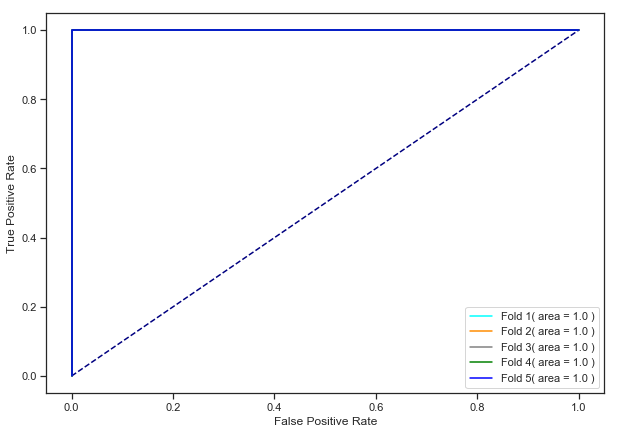

In [322]:
PlotOverfitRoc(tpr_train_knn, fpr_train_knn, train_auc_list_knn)

### It seems like the model is overfitting, let's try with fewer hyperparameters  ( decresing complexity )

In [323]:
clf2 = neighbors.KNeighborsClassifier(n_neighbors = 11, metric = 'manhattan')
tpr_test_knn2, fpr_test_knn2, tpr_mean_knn2, auc_mean_knn2, tpr_train_knn2, fpr_train_knn2, train_auc_list_knn2, test_auc_list_knn2,cml_knn2,accuracy_knn2\
= KfoldRoc(z_data_X.values, z_data_y.values, clf2, 5,'KNN')

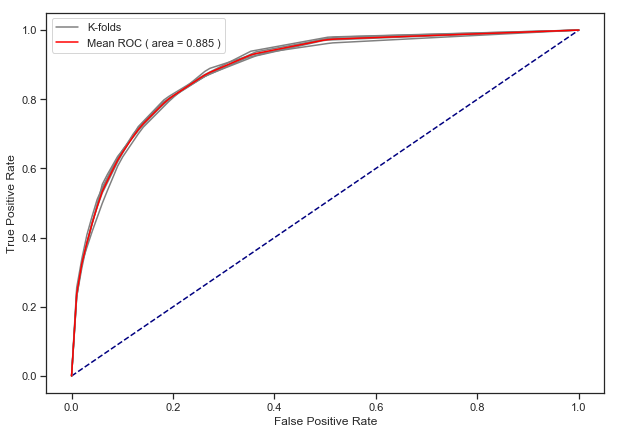

In [325]:
PlotMeanRoc(tpr_test_knn2, fpr_test_knn2, tpr_mean_knn2, auc_mean_knn2)

### Fold ROC

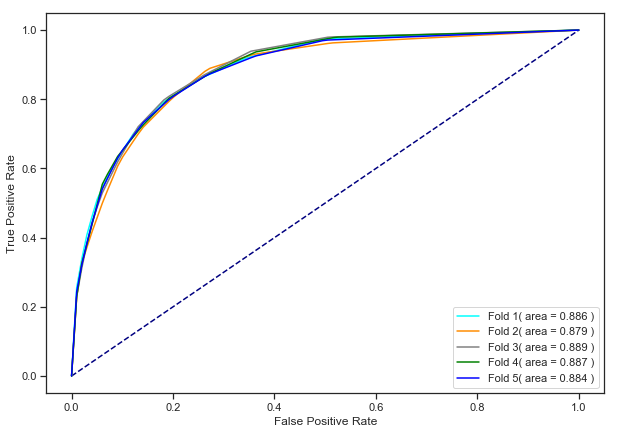

In [326]:
PlotFoldRoc(tpr_test_knn2, fpr_test_knn2, tpr_mean_knn2, test_auc_list_knn2)

### Overfitting check

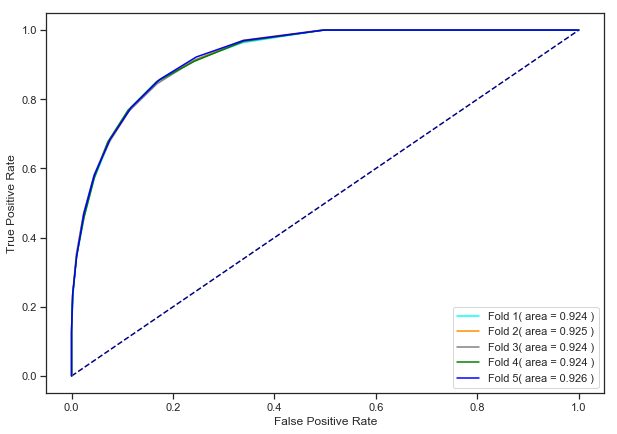

In [327]:
PlotOverfitRoc(tpr_train_knn2, fpr_train_knn2, train_auc_list_knn2)

**We can see that both AUC on test and on train is went down, so actualy the model was not overfitted**

**Saving means to dictionaries**

In [328]:
AUC_mean["KNN"] = auc_mean_knn

In [329]:
TPR_mean["KNN"] = tpr_mean_knn

In [ ]:
Accuracy_mean["KNN"] = accuracy_knn

_____

# Naive Bayes

In [330]:
gnb = GaussianNB()
tpr_test_nb, fpr_test_nb, tpr_mean_nb, auc_mean_nb, tpr_train_nb, fpr_train_nb, train_auc_list_nb, test_auc_list_nb,cml_nb,accuracy_nb \
= KfoldRoc(z_data_X.values, z_data_y.values, gnb, 5,'NB')

## Confusion Matrix

In [331]:
for i in range(len(cml_nb)):
    print("Confusion Matrix for fold " + str(i+1)+":\n")
    con_m = pd.DataFrame(cml_nb[i], index = ["Predicted positive","Predicted negative"])
    con_m.columns = ['Actual positive', 'Actual negative' ]
    print(con_m)
    print('\n')
    print('-----------------------------------------------------')
    print('\n')
    

Confusion Matrix for fold 1:

                    Actual positive  Actual negative
Predicted positive              959              837
Predicted negative              233             2818


-----------------------------------------------------


Confusion Matrix for fold 2:

                    Actual positive  Actual negative
Predicted positive              938              893
Predicted negative              216             2800


-----------------------------------------------------


Confusion Matrix for fold 3:

                    Actual positive  Actual negative
Predicted positive              982              879
Predicted negative              212             2774


-----------------------------------------------------


Confusion Matrix for fold 4:

                    Actual positive  Actual negative
Predicted positive              989              921
Predicted negative              179             2758


-----------------------------------------------------


Confusion Ma

### Mean ROC Plot

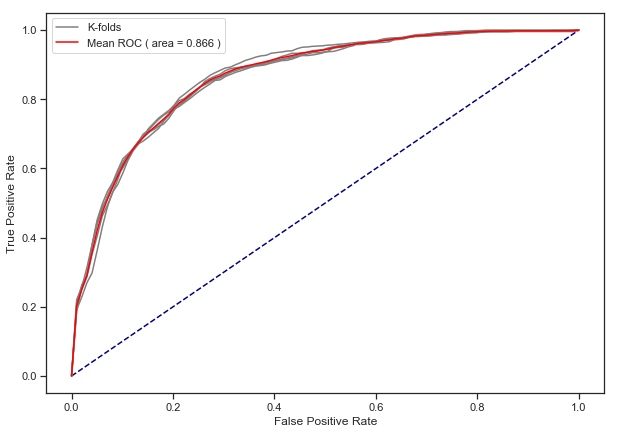

In [332]:
PlotMeanRoc(tpr_test_nb, fpr_test_nb, tpr_mean_nb, auc_mean_nb)

### Fold ROC

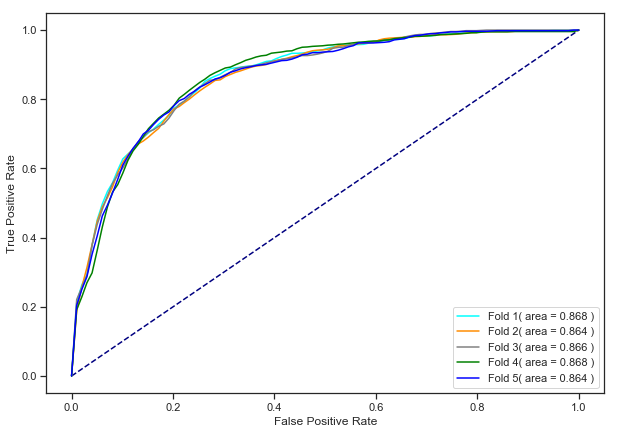

In [333]:
PlotFoldRoc(tpr_test_nb, fpr_test_nb, tpr_mean_nb, test_auc_list_nb)

### Overfitting Check

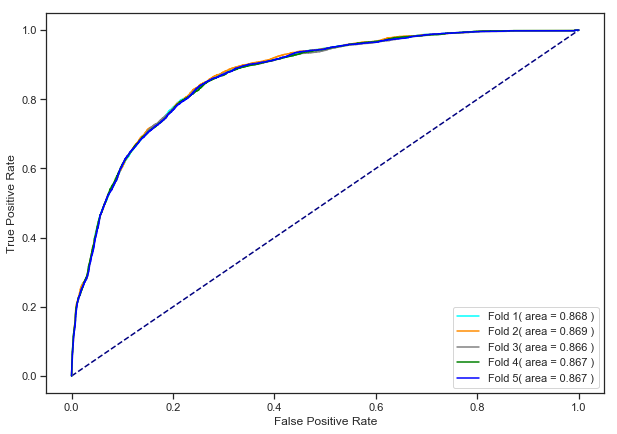

In [334]:
PlotOverfitRoc(tpr_train_nb, fpr_train_nb, train_auc_list_nb)

**We can see above that there is no overfitting, model have almost the same abilities when getting data never seen before**

In [335]:
AUC_mean["Naive Bayes"] = auc_mean_nb

In [336]:
TPR_mean["Naive Bayes"] = tpr_mean_nb

In [ ]:
Accuracy_mean["Naive Bayes"] = accuracy_nb

______

# Advanced Models and Evaluations

# ANN

### Searching for best given hyperparameters

In [337]:
AnnParametersOptions = {'activation' : ["logistic", "relu"], #
                      'hidden_layer_sizes' : [(100,), # 1 large hidden layer
                                             (50, 50), # 2 medium size layers
                                             (20, 20, 10, 10, 10)], # multiple small sized layers
                      'batch_size' : [10, 50],
                      'learning_rate_init' : [0.1, 0.01], #In some of the runs we saw that the network got stuck on a local min, for this reason we enlearge the defualt momentum
                      'max_iter' : [1500],
                       'random_state' :[23]}

kfold = KFold(n_splits = 5, random_state = 23)
GS_ANN = GridSearchCV(MLPClassifier(), AnnParametersOptions, cv = kfold, scoring = 'roc_auc', n_jobs = -1)

GS_ANN.fit(z_data_X, z_data_y);

In [338]:
print ('Neural Network chosen parameters (recieved best AUC): {}'.format(GS_ANN.best_params_))
print ("Neural Network AUC score with the chosen parameters: ", GS_ANN.best_score_)

Neural Network chosen parameters (recieved best AUC): {'activation': 'relu', 'batch_size': 10, 'hidden_layer_sizes': (20, 20, 10, 10, 10), 'learning_rate_init': 0.01, 'max_iter': 1500, 'random_state': 23}
Neural Network AUC score with the chosen parameters:  0.9044598935483027


### MLP with best params

In [339]:
ann_clf = MLPClassifier(**GS_ANN.best_params_)
tpr_test_ann, fpr_test_ann, tpr_mean_ann, auc_mean_ann, tpr_train_ann, fpr_train_ann, train_auc_list_ann, test_auc_list_ann,cml_ann,accuracy_ann\
= KfoldRoc(z_data_X.values, z_data_y.values, ann_clf, 5,'ANN')

### Mean ROC

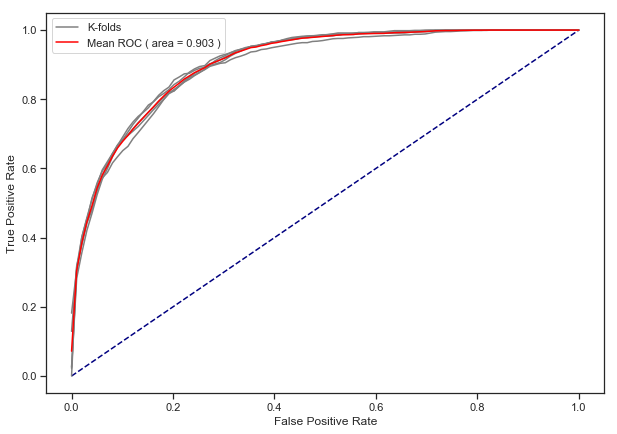

In [340]:
PlotMeanRoc(tpr_test_ann, fpr_test_ann, tpr_mean_ann, auc_mean_ann)

### Fold ROC

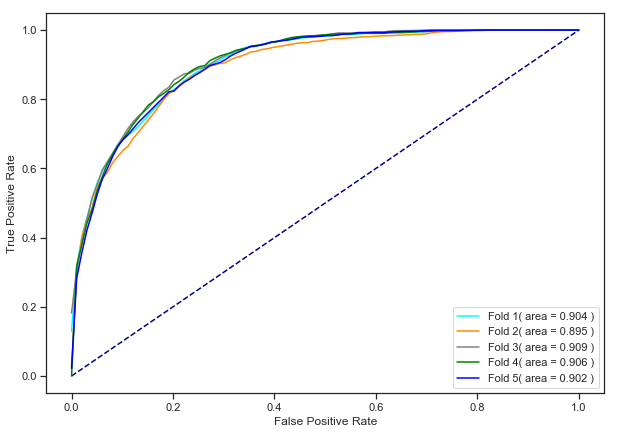

In [341]:
PlotFoldRoc(tpr_test_ann, fpr_test_ann, tpr_mean_ann, test_auc_list_ann)

### Overfitting check

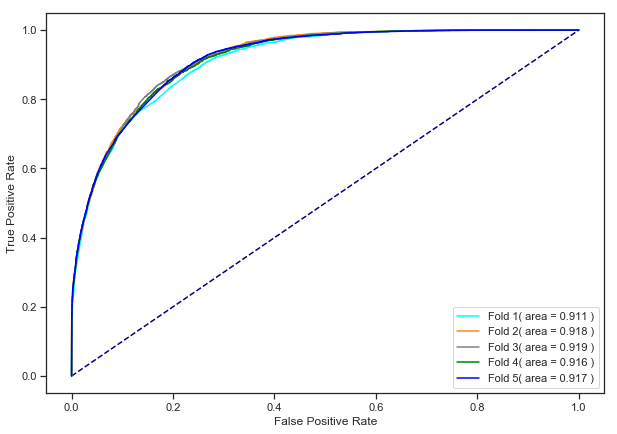

In [342]:
PlotOverfitRoc(tpr_train_ann, fpr_train_ann, train_auc_list_ann)

In [343]:
AUC_mean["FF Neural Network"] = auc_mean_ann

In [344]:
TPR_mean["FF Neural Network"] = tpr_mean_ann

In [ ]:
Accuracy_mean["FF Neural Network"] = accuracy_ann

_______

# Random Forest

### Finding best of our hyperparameters

In [404]:
parametersOptions = {'min_samples_split':[4, 8, 16, 20], 
                     'max_depth':[5,8,10,20,30],
                     'criterion':['gini', 'entropy'],
                     'n_estimators':[30], 
                     'random_state':[23]}

kfold = KFold(n_splits = 5, random_state = 23)
GS_RF = GridSearchCV(RandomForestClassifier(), parametersOptions, cv = kfold, scoring='roc_auc',n_jobs = -1)

GS_RF.fit(z_data_X, z_data_y);

In [405]:
print ('Random Forest chosen parameters (recieved best AUC): {}'.format(GS_RF.best_params_))
print ("Random Forest AUC score with the chosen parameters: ", GS_RF.best_score_)

Random Forest chosen parameters (recieved best AUC): {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 30, 'random_state': 23}
Random Forest AUC score with the chosen parameters:  0.9050363145417558


### Random Forest with best params

In [406]:
rf_clf = RandomForestClassifier(**GS_RF.best_params_)
tpr_test_rf, fpr_test_rf, tpr_mean_rf, auc_mean_rf, tpr_train_rf, fpr_train_rf, train_auc_list_rf, test_auc_list_rf,cml_rf,accuracy_rf\
= KfoldRoc(z_data_X.values, z_data_y.values, rf_clf, 5,'RF')

### Mean ROC

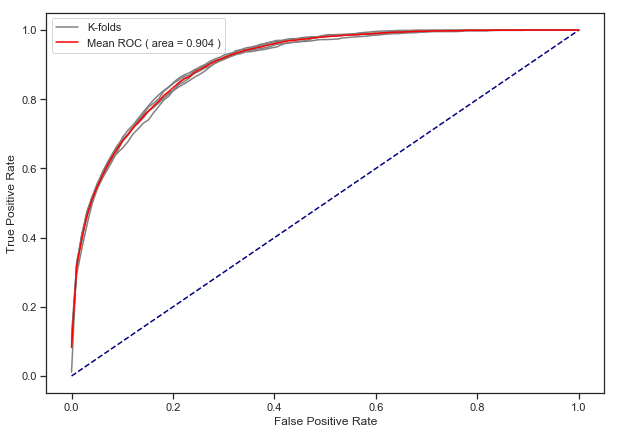

In [407]:
PlotMeanRoc(tpr_test_rf, fpr_test_rf, tpr_mean_rf, auc_mean_rf)

### Fold ROC

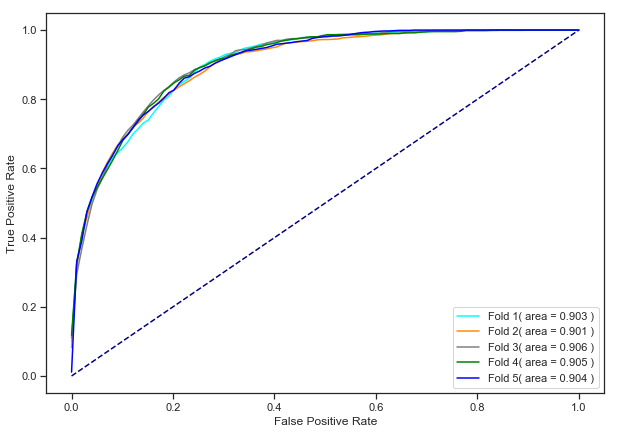

In [408]:
PlotFoldRoc(tpr_test_rf, fpr_test_rf, tpr_mean_rf, test_auc_list_rf)

### Overfitting check

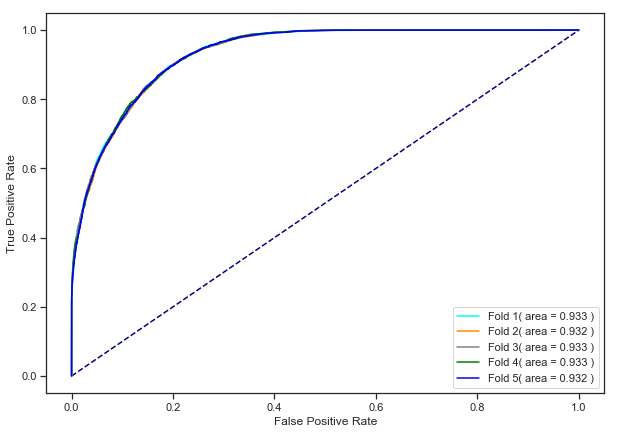

In [409]:
PlotOverfitRoc(tpr_train_rf, fpr_train_rf, train_auc_list_rf)

In [410]:
AUC_mean["Random Forest"] = auc_mean_rf

In [411]:
TPR_mean["Random Forest"] = tpr_mean_rf

In [412]:
Accuracy_mean["Random Forest"] = accuracy_rf

### Running Random Forest with fewer parameters to check overfitting ( decresing complexity )

In [417]:
rf_clf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', max_depth = 20, min_samples_split = 20, random_state = 23)
tpr_test_rf, fpr_test_rf, tpr_mean_rf, auc_mean_rf, tpr_train_rf, fpr_train_rf, train_auc_list_rf, test_auc_list_rf,cml_rf,accuracy_rf\
= KfoldRoc(z_data_X.values, z_data_y.values, rf_clf, 5,'RF')

### Mean ROC

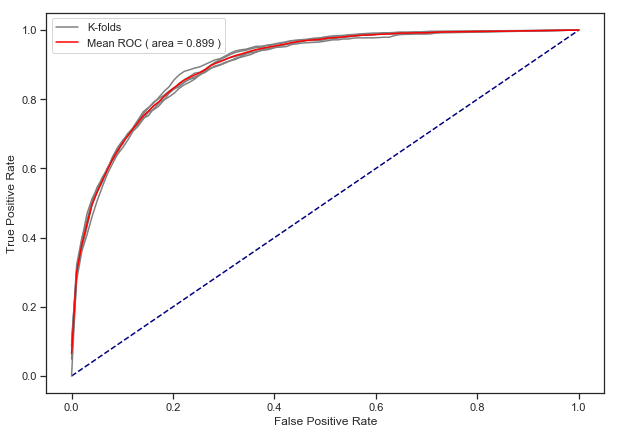

In [418]:
PlotMeanRoc(tpr_test_rf, fpr_test_rf, tpr_mean_rf, auc_mean_rf)

### Fold's ROC

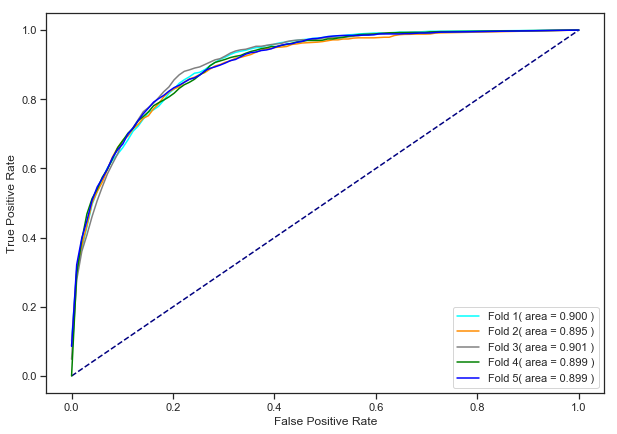

In [419]:
PlotFoldRoc(tpr_test_rf, fpr_test_rf, tpr_mean_rf, test_auc_list_rf)

### Overfitting check

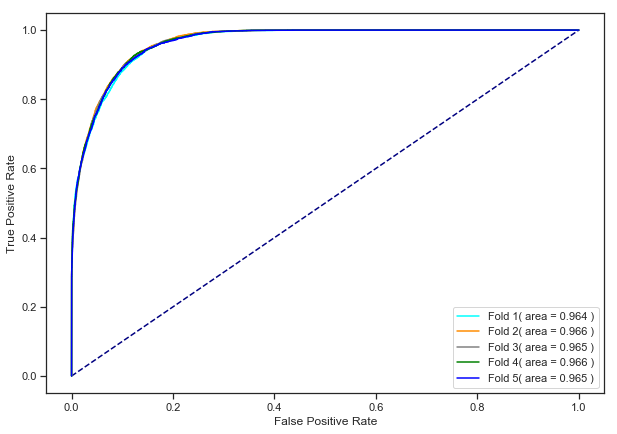

In [420]:
PlotOverfitRoc(tpr_train_rf, fpr_train_rf, train_auc_list_rf)

**We can see that both AUC on test and on train is went down, so actualy the model was not overfitted**

____

# AdaBoost Classifier

### Choosing best of our hyperparameters

In [425]:
parametersOptions = {'n_estimators':[100,500,1000],
                     'learning_rate': [0.01,0.05,0.1,0.3,1],
                    'random_state' :[23]}

kfold = KFold(n_splits = 5, random_state = 23)
GS_AB = GridSearchCV( AdaBoostClassifier() , parametersOptions, cv = kfold, scoring='roc_auc',n_jobs = -1)

GS_AB.fit(z_data_X, z_data_y);

In [426]:
print ('AdaBoost chosen parameters (recieved best AUC): {}'.format(GS_AB.best_params_))
print ("AdaBoost AUC score with the chosen parameters: ", GS_AB.best_score_)

AdaBoost chosen parameters (recieved best AUC): {'learning_rate': 0.1, 'n_estimators': 1000, 'random_state': 23}
AdaBoost AUC score with the chosen parameters:  0.9059566175857598


### AdaBoost with best params

In [428]:
ab_clf = AdaBoostClassifier(**GS_AB.best_params_)
tpr_test_ab, fpr_test_ab, tpr_mean_ab, auc_mean_ab, tpr_train_ab, fpr_train_ab, train_auc_list_ab, test_auc_list_ab,cml_ab,accuracy_ab\
= KfoldRoc(z_data_X.values, z_data_y.values, ab_clf, 5,'AB')

### Mean ROC

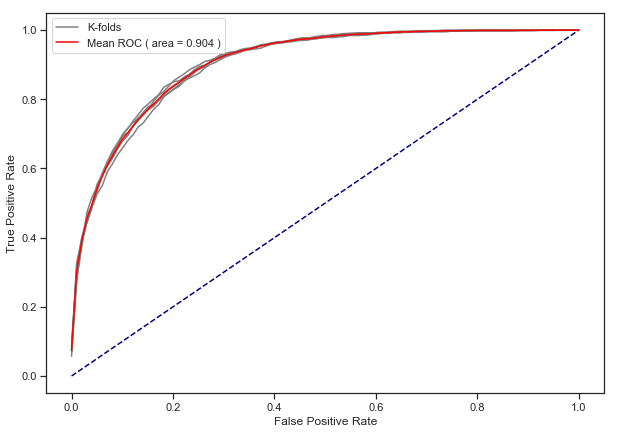

In [429]:
PlotMeanRoc(tpr_test_ab, fpr_test_ab, tpr_mean_ab, auc_mean_ab)

### Fold's ROC

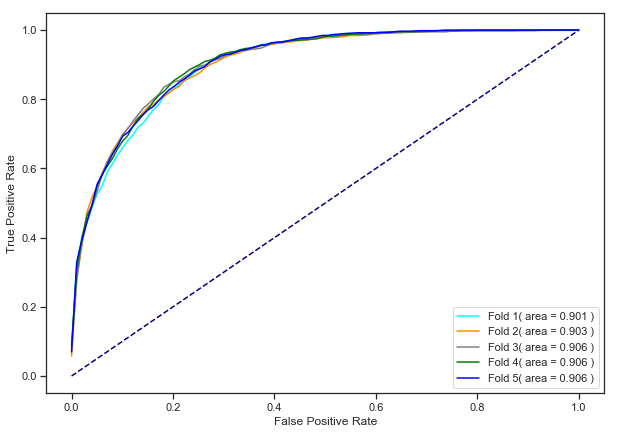

In [430]:
PlotFoldRoc(tpr_test_ab, fpr_test_ab, tpr_mean_ab, test_auc_list_ab)

### Overfitting check

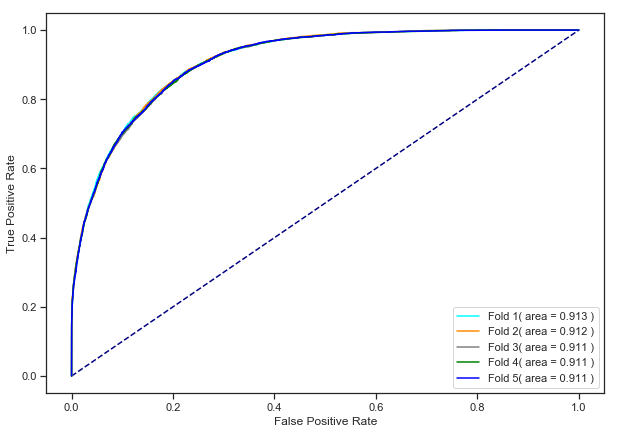

In [431]:
PlotOverfitRoc(tpr_train_ab, fpr_train_ab, train_auc_list_ab)

In [432]:
AUC_mean["AdaBoost"] = auc_mean_ab

In [433]:
TPR_mean["AdaBoost"] = tpr_mean_ab

In [434]:
Accuracy_mean["AdaBoost"] = accuracy_ab

___

# Models Comparison

### Function to plot mean ROC of every model

In [435]:
def PlotModelsRoc():
    #building graph
    plt.figure(figsize=(10,7)) 
    plt.plot([0,1],[0,1], color = 'navy', linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean ROC of all models')
    colors = ['blue', 'darkorange', 'green', 'aqua','magenta', 'cornflowerblue', 'yellow', 'black','grey',]
    auc_max = 0
    i_auc_max = 0
    for i in range(len(AUC_mean)):
        plt.plot(np.linspace(0,1,100), TPR_mean[list(AUC_mean.keys())[i]], color = colors[i], \
                 label = 'ROC curve of ' + str(list(AUC_mean.keys())[i])+ ' ( area = ' + \
                 ('%.5s' %str(AUC_mean[list(AUC_mean.keys())[i]])) + ' )')
        if auc_max <= list(AUC_mean.values())[i]:
            auc_max = list(AUC_mean.values())[i]
            i_auc_max = i
    plt.legend()
    plt.show()
    
    print('\nModel with the highest AUC: ' + str(list(AUC_mean.keys())[i_auc_max]) + ' = ' + \
          str(auc_max))

### Graph of mean ROC for every model

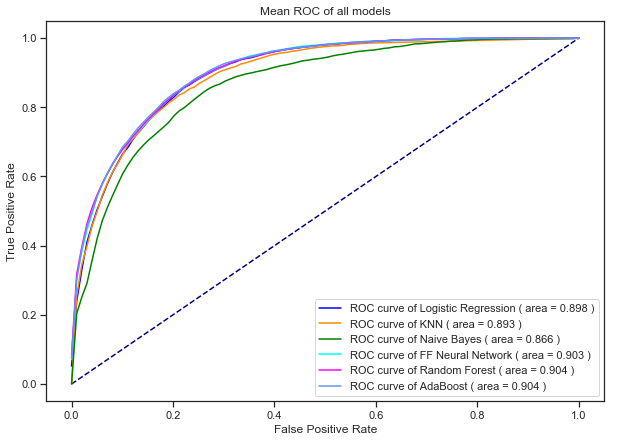


Model with the highest AUC: AdaBoost = 0.9049931942618435


In [436]:
PlotModelsRoc()

### <font color = "blue">Chosen model: AdaBoost: AUC 0.90499</font>

___

# Final Predictions

## Fitting model to the entire Train set

In [437]:
best_model = AdaBoostClassifier(learning_rate = 0.1,
                                  n_estimators = 1000,
                                  random_state = 23)

best_model.fit(z_data_X, z_data_y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=1000, random_state=23)

## Creating predictions for Test set

In [448]:
test_predictions = best_model.predict(z_final_test)

In [449]:
predictionsDF = pd.DataFrame(test_predictions)

In [458]:
predictionsDF.rename(columns = {0 : 'label'}, inplace = True)

### Saving predictions to csv

In [463]:
predictionsDF = pd.DataFrame(predictionsDF)
predictionsDF.to_csv('predictions_on_test.csv')

In [465]:
#predictionsDF